# Prediction Of Next Passengers Taxi Ride

In [2]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime
import time
import seaborn as sns
import os
import math
import matplotlib
matplotlib.use('nbagg')
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
warnings.simplefilter('ignore')

In [3]:
data_2015 = dd.read_csv("ytaxi2015.csv")

In [4]:
data_2015.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [5]:
data_2015.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [6]:
print("Number of columns = "+str(len(data_2015.columns)))

Number of columns = 19


In [60]:
print("Total Number of Passengers in January 2015 = "+str(data_2015["passenger_count"].sum(axis = 0).compute()))

Total Number of Passengers in January 2015 = 21437303


In [64]:
print("Number of nan values = {}".format(data_2015.isnull().sum().compute()))

Number of nan values = VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    3
total_amount             0
dtype: int64


### Pickup 

In [8]:
outside_NYC = data_2015[((data_2015.pickup_latitude <= 40.5774) | (data_2015.pickup_longitude <= -74.15) | (data_2015.pickup_latitude >= 40.9176) | (data_2015.pickup_longitude >= -73.7004))]
m = folium.Map(location = [40.5774, -73.7004], tiles = "openstreet map")

outside_pickups = outside_NYC.head(25000)

for i,j in outside_pickups.iterrows():
    if j["pickup_latitude"] != 0:
        folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
m

### Dropoff

In [9]:
outside_NYC = data_2015[((data_2015.dropoff_latitude <= 40.5774) | (data_2015.dropoff_longitude <= -74.15) | (data_2015.dropoff_latitude >= 40.9176) | (data_2015.dropoff_longitude >= -73.7004))]
m = folium.Map(location = [40.5774, -73.7004], tiles = "openstreet map")

outside_dropoff = outside_NYC.head(25000)

for i,j in outside_dropoff.iterrows():
    if j["dropoff_latitude"] != 0:
        folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
m

In [10]:
def timeToUnix(t):
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S") 
    t_tuple = change.timetuple() 
    return time.mktime(t_tuple) + 3600  
def dfWithTripTimes(df):
    startTime = datetime.now()
    duration = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].compute()
    pickup_time = [timeToUnix(pkup) for pkup in duration["tpep_pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duration["tpep_dropoff_datetime"].values]
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  
    
    NewFrame = df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    NewFrame["trip_duration"] = trip_duration
    NewFrame["pickup_time"] = pickup_time
    NewFrame["speed"] = (NewFrame["trip_distance"]/NewFrame["trip_duration"])*60
    
    print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    return NewFrame

In [11]:
new_frame = dfWithTripTimes(data_2015)

Time taken for creation of dataframe is 0:09:05.904024


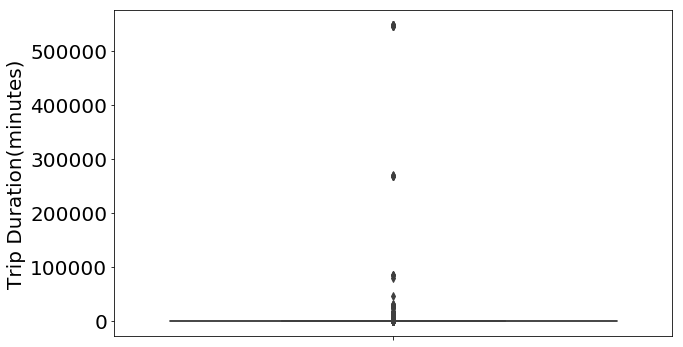

In [9]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_duration", data = new_frame, orient = "v")
plt.tick_params(labelsize = 20)
plt.ylabel("Trip Duration(minutes)", fontsize = 20)
plt.show()

In [10]:
quantile_tripDuration = new_frame.trip_duration.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [11]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of Trip Duration is {}min".format((int(i*100)), quantile_tripDuration[i]))

0th percentile value of Trip Duration is -1211.0166666666667min
10th percentile value of Trip Duration is 3.8333333333333335min
20th percentile value of Trip Duration is 5.383333333333334min
30th percentile value of Trip Duration is 6.816666666666666min
40th percentile value of Trip Duration is 8.3min
50th percentile value of Trip Duration is 9.95min
60th percentile value of Trip Duration is 11.866666666666667min
70th percentile value of Trip Duration is 14.283333333333333min
80th percentile value of Trip Duration is 17.633333333333333min
90th percentile value of Trip Duration is 23.45min
100th percentile value of Trip Duration is 548555.6333333333min


In [12]:
qValues = np.round(np.arange(0.90, 1.01, 0.01), 2)
for i in qValues:
    print("{} percentile value of Trip Duration is {}min".format((int(i*100)), quantile_tripDuration[i]))

90 percentile value of Trip Duration is 23.45min
91 percentile value of Trip Duration is 24.35min
92 percentile value of Trip Duration is 25.383333333333333min
93 percentile value of Trip Duration is 26.55min
94 percentile value of Trip Duration is 27.933333333333334min
95 percentile value of Trip Duration is 29.583333333333332min
96 percentile value of Trip Duration is 31.68333333333333min
97 percentile value of Trip Duration is 34.46666666666667min
98 percentile value of Trip Duration is 38.71666666666667min
99 percentile value of Trip Duration is 46.75min
100 percentile value of Trip Duration is 548555.6333333333min


In [12]:
new_frame_cleaned = new_frame[(new_frame.trip_duration>1) & (new_frame.trip_duration<720)]

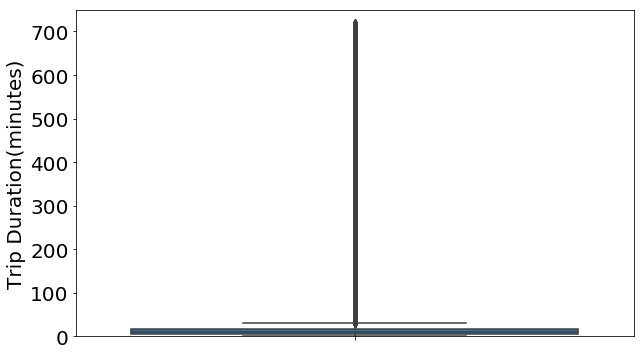

In [14]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_duration", data = new_frame_cleaned, orient = "v")
plt.ylim(ymin = 1, ymax = 750)
plt.tick_params(labelsize = 20)
plt.ylabel("Trip Duration(minutes)", fontsize = 20)
plt.show()

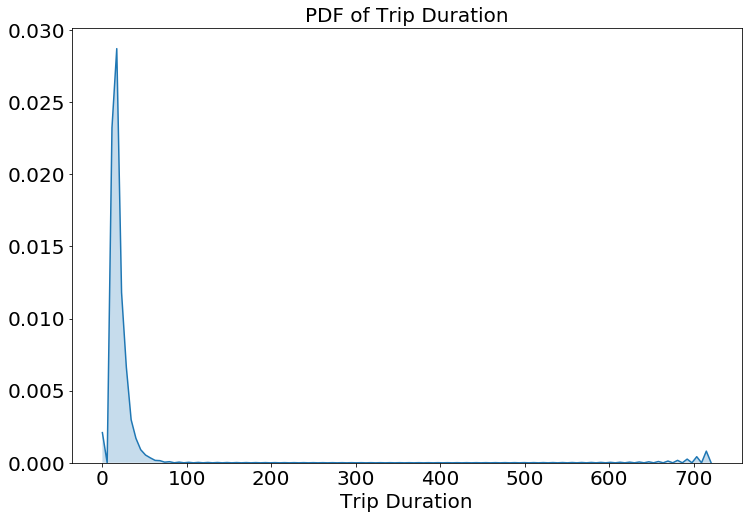

In [15]:
plt.figure(figsize = (12,8))
sns.kdeplot(new_frame_cleaned["trip_duration"].values, shade = True, cumulative = False)
plt.tick_params(labelsize = 20)
plt.xlabel("Trip Duration", fontsize = 20)
plt.title("PDF of Trip Duration", fontsize = 20)
plt.show()

## Speed

In [16]:
def changingLabels(num):
    if num < 10**3:
        return num
    elif num>=10**3 and num < 10**6:
        return str(num/10**3)+"k"
    elif num>=10**6 and num < 10**9:
        return str(num/10**6) + "M"
    else:
        return str(num/10**9) + "B"

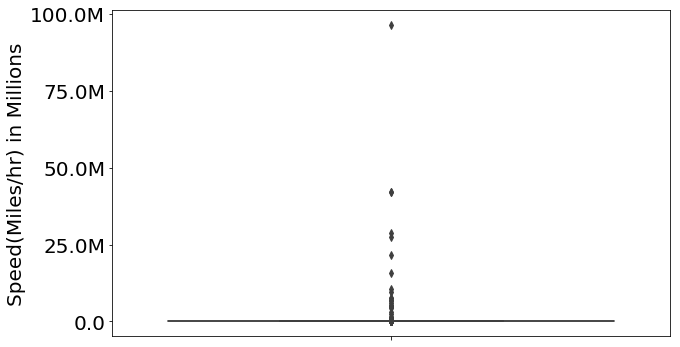

In [17]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("speed", data = new_frame_cleaned, orient = "v")

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr) in Millions", fontsize = 20)
plt.show()

In [18]:
quantile_speed = new_frame_cleaned.speed.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [19]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 4)
for i in qValues:
    print("{}th percentile value of speed is {}miles/hr".format(int(i*100), quantile_speed[i]))

0th percentile value of speed is 0.0miles/hr
10th percentile value of speed is 6.409495548961425miles/hr
20th percentile value of speed is 7.80952380952381miles/hr
30th percentile value of speed is 8.929133858267717miles/hr
40th percentile value of speed is 9.98019801980198miles/hr
50th percentile value of speed is 11.06865671641791miles/hr
60th percentile value of speed is 12.286689419795222miles/hr
70th percentile value of speed is 13.796407185628745miles/hr
80th percentile value of speed is 15.963224893917962miles/hr
90th percentile value of speed is 20.186915887850468miles/hr
100th percentile value of speed is 192857142.85714284miles/hr


In [20]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of speed is {}miles/hr".format(int(i*100), quantile_speed[i]))

91 percentile value of speed is 20.916454400875093miles/hr
92 percentile value of speed is 21.752988047808763miles/hr
93 percentile value of speed is 22.721893491124263miles/hr
94 percentile value of speed is 23.844155844155843miles/hr
95 percentile value of speed is 25.182552504038775miles/hr
96 percentile value of speed is 26.80851063829787miles/hr
97 percentile value of speed is 28.84304932735426miles/hr
98 percentile value of speed is 31.591128254580514miles/hr
99 percentile value of speed is 35.75135055113604miles/hr
100 percentile value of speed is 192857142.85714284miles/hr


In [21]:
qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
quantile_speed = new_frame_cleaned.speed.quantile(qValues)
for i in qValues:
    print("{} percentile value of speed is {}miles/hr".format((i*100), quantile_speed[i]))

99.1 percentile value of speed is 36.31081290376664miles/hr
99.2 percentile value of speed is 36.91470054446461miles/hr
99.3 percentile value of speed is 37.588235294117645miles/hr
99.4 percentile value of speed is 38.330334294788756miles/hr
99.5 percentile value of speed is 39.17580011612381miles/hr
99.6 percentile value of speed is 40.15384615384615miles/hr
99.7 percentile value of speed is 41.338029086798095miles/hr
99.8 percentile value of speed is 42.866243893093184miles/hr
99.9 percentile value of speed is 45.310675074725154miles/hr
100.0 percentile value of speed is 192857142.85714284miles/hr


In [13]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.speed>0) & (new_frame_cleaned.speed<45.31)]

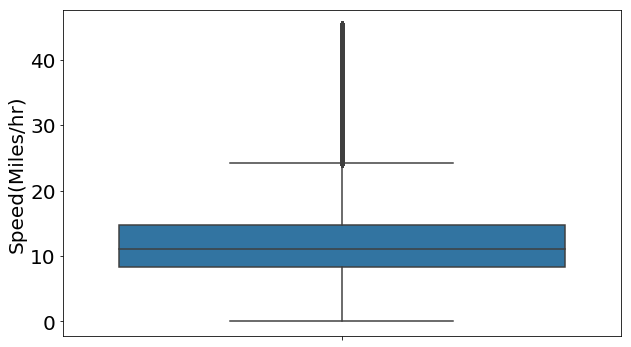

In [23]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("speed", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr)", fontsize = 20)
plt.show()

In [24]:
Average_speed = sum(new_frame_cleaned.speed)/len(new_frame_cleaned.speed)
print("Average Speed of Taxis around NYC = "+str(Average_speed))

Average Speed of Taxis around NYC = 12.452320837813998


In [25]:
print("Speed of Taxis around NYC per 10 minutes = "+str(Average_speed/6)+" per 10 minutes.")

Speed of Taxis around NYC per 10 minutes = 2.075386806302333 per 10 minutes.


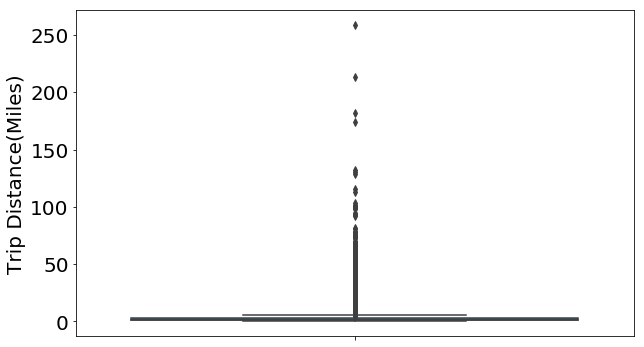

In [26]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Distance(Miles)", fontsize = 20)
plt.show()

In [27]:
quantile_tripDistance = new_frame_cleaned.trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [28]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip distance is {}miles".format(int(i*100), quantile_tripDistance[i]))

0th percentile value of trip distance is 0.01miles
10th percentile value of trip distance is 0.67miles
20th percentile value of trip distance is 0.9000000000000001miles
30th percentile value of trip distance is 1.1miles
40th percentile value of trip distance is 1.39miles
50th percentile value of trip distance is 1.7miles
60th percentile value of trip distance is 2.08miles
70th percentile value of trip distance is 2.61miles
80th percentile value of trip distance is 3.6miles
90th percentile value of trip distance is 5.98miles
100th percentile value of trip distance is 258.9miles


In [29]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format(int(i*100), quantile_tripDistance[i]))

91 percentile value of trip distance is 6.469999999999999miles
92 percentile value of trip distance is 7.09miles
93 percentile value of trip distance is 7.87miles
94 percentile value of trip distance is 8.739999999999998miles
95 percentile value of trip distance is 9.6miles
96 percentile value of trip distance is 10.6miles
97 percentile value of trip distance is 12.1miles
98 percentile value of trip distance is 16.06miles
99 percentile value of trip distance is 18.18miles
100 percentile value of trip distance is 258.9miles


In [30]:
quantile_tripDistance = new_frame_cleaned.trip_distance.quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format((i*100), quantile_tripDistance[i]))

99.1 percentile value of trip distance is 18.37miles
99.2 percentile value of trip distance is 18.6miles
99.3 percentile value of trip distance is 18.84miles
99.4 percentile value of trip distance is 19.14miles
99.5 percentile value of trip distance is 19.5miles
99.6 percentile value of trip distance is 19.97miles
99.7 percentile value of trip distance is 20.51miles
99.8 percentile value of trip distance is 21.23miles
99.9 percentile value of trip distance is 22.58miles
100.0 percentile value of trip distance is 258.9miles


In [14]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.trip_distance>0) & (new_frame_cleaned.trip_distance<23)]

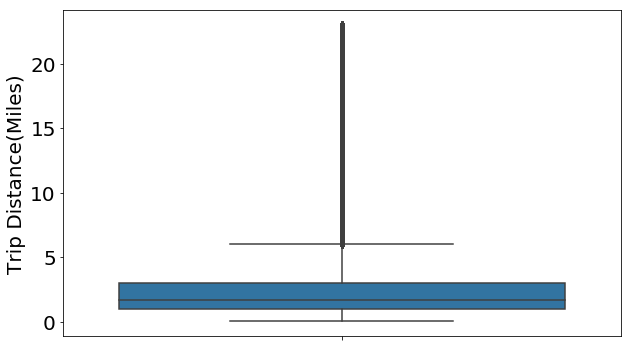

In [32]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Distance(Miles)", fontsize = 20)
plt.show()

## Total Fare

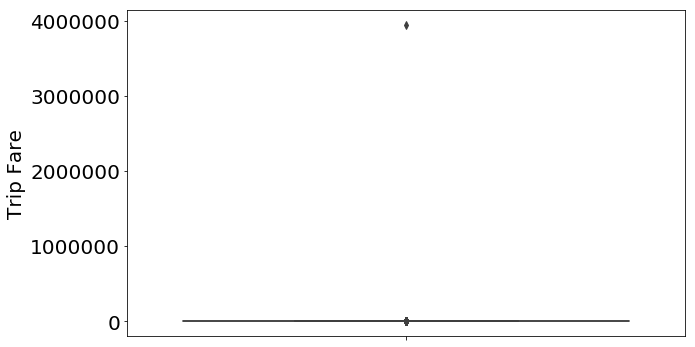

In [33]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("total_amount", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Fare", fontsize = 20)
plt.show()

In [34]:
quantile_totalAmount = new_frame_cleaned.total_amount.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [35]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip fare is {}".format(int(i*100), quantile_totalAmount[i]))

0th percentile value of trip fare is -242.55
10th percentile value of trip fare is 6.35
20th percentile value of trip fare is 7.799999999999999
30th percentile value of trip fare is 8.8
40th percentile value of trip fare is 9.8
50th percentile value of trip fare is 11.16
60th percentile value of trip fare is 12.8
70th percentile value of trip fare is 14.8
80th percentile value of trip fare is 18.3
90th percentile value of trip fare is 25.8
100th percentile value of trip fare is 3950611.6


In [36]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format(int(i*100), quantile_totalAmount[i]))

91 percentile value of trip fare is 27.3
92 percentile value of trip fare is 29.13
93 percentile value of trip fare is 31.549999999999997
94 percentile value of trip fare is 34.63
95 percentile value of trip fare is 38.13
96 percentile value of trip fare is 42.13
97 percentile value of trip fare is 47.53
98 percentile value of trip fare is 57.68
99 percentile value of trip fare is 65.8
100 percentile value of trip fare is 3950611.6


In [37]:
quantile_totalAmount = new_frame_cleaned.total_amount.quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format((i*100), quantile_totalAmount[i]))

99.1 percentile value of trip fare is 67.55
99.2 percentile value of trip fare is 68.8
99.3 percentile value of trip fare is 69.6
99.4 percentile value of trip fare is 69.73
99.5 percentile value of trip fare is 69.73
99.6 percentile value of trip fare is 69.76
99.7 percentile value of trip fare is 72.46
99.8 percentile value of trip fare is 75.16
99.9 percentile value of trip fare is 86.6
100.0 percentile value of trip fare is 3950611.6


In [15]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.total_amount>0) & (new_frame_cleaned.total_amount<86.6)]

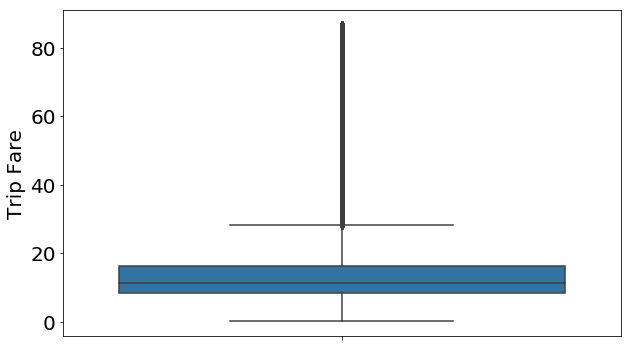

In [39]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("total_amount", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Fare", fontsize = 20)
plt.show()

In [16]:
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.pickup_latitude >= 40.5774) & (new_frame_cleaned.pickup_latitude <= 40.9176)) & ((new_frame_cleaned.pickup_longitude >= -74.15) & (new_frame_cleaned.pickup_longitude <= -73.7004)))]

In [17]:
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

pickups_within_NYC = new_frame_cleaned.sample(n = 500)

for i,j in pickups_within_NYC.iterrows():
    folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
m

In [18]:
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.dropoff_latitude >= 40.5774) & (new_frame_cleaned.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned.dropoff_longitude >= -74.15) & (new_frame_cleaned.dropoff_longitude <= -73.7004)))]

In [19]:
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

dropoff_within_NYC = new_frame_cleaned.sample(n = 500)

for i,j in dropoff_within_NYC.iterrows():
    folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
m

In [20]:
print("Fraction of cleaned points",str(new_frame_cleaned.shape[0]/new_frame.shape[0]))

Fraction of cleaned points 0.9680387130396095


In [21]:
print("Total number of outliers and erroneous points removed = ",str(new_frame.shape[0] - new_frame_cleaned.shape[0]))

Total number of outliers and erroneous points removed =  407474


In [44]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
neighbors = []

def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                distance = distance/(1.60934*1000)   
                min_distance = min(min_distance, distance) 
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [45]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 8.0
Minimum distance between any two clusters = 0.869755699691745
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 5.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 15.0
Minimum distance between any two clusters = 0.6971933153106344
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 7.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 23.0
Minimum distance between any two clusters = 0.4247618207394735
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 10.0
Avg. Number clusters outside of vicinity where inte

In [22]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)
new_frame_cleaned["pickup_cluster"] = regions.predict(new_frame_cleaned[["pickup_latitude", "pickup_longitude"]])

In [23]:
new_frame_cleaned.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0         -73.974785         40.750618         17.05      18.050000   
1         -73.994415         40.759109         17.80      19.833333   
2         -73.951820         40.824413         10.80      10.050000   
3         -74.004326         40.719986          4.80       1.866667   
4         -74.004181         40.742653         16.30      19.316667   

    pickup_time      speed  pickup_cluster  
0  1.421349e+09   5.285319              17  
1  1.420922e+09   9.983193               8  
2  1.420922e+09  10.746269              23  
3  1.420922e+09  16.071429              22  
4  1.420922e+09   9.318378               4

#### Plotting cluster centers

In [24]:
centerOfRegions = regions.cluster_centers_
noOfClusters = len(centerOfRegions)
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

for i in range(noOfClusters):
    folium.Marker([centerOfRegions[i][0], centerOfRegions[i][1]], popup = (str(np.round(centerOfRegions[i][0], 2))+", "+str(np.round(centerOfRegions[i][1], 2)))).add_to(m)
m

#### Plotting Regions in NYC

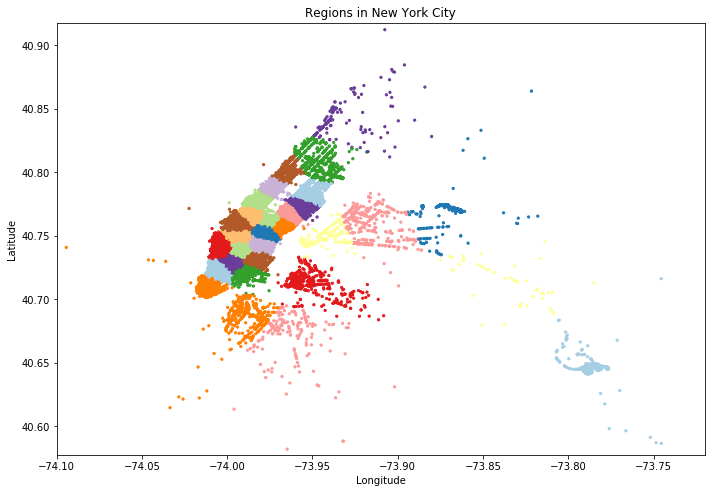

In [53]:
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = new_frame_cleaned.pickup_longitude.values[:70000], y = new_frame_cleaned.pickup_latitude.values[:70000], c = new_frame_cleaned.pickup_cluster.values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

## Time Binning

In [22]:
def pickup_10min_bins(dataframe, month, year):
    pickupTime = dataframe["pickup_time"].values
    unixTime = [1420070400, 1451606400]
    unix_year = unixTime[year-2015]
    time_10min_bin = [int((i - unix_year)/600) for i in pickupTime]
    dataframe["time_bin"] = np.array(time_10min_bin)
    return dataframe

In [24]:
jan_2015_data = pickup_10min_bins(new_frame_cleaned, 1, 2015)

In [25]:
jan_2015_data.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0         -73.974785         40.750618         17.05      18.050000   
1         -73.994415         40.759109         17.80      19.833333   
2         -73.951820         40.824413         10.80      10.050000   
3         -74.004326         40.719986          4.80       1.866667   
4         -74.004181         40.742653         16.30      19.316667   

    pickup_time      speed  pickup_cluster  time_bin  
0  1.421349e+09   5.285319              17      2130  
1  1.420922e+09   9.983193              16      1419  
2  1.420922e+09  10.746269              24      1419  
3  1.420922e+09  16.071429              20      1419  
4  1.420922e+09   9.318378               6      1419

In [26]:
print("There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015: ", str(len(np.unique(jan_2015_data["time_bin"]))))

There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015:  4464


In [27]:
jan_2015_timeBin_groupBy = jan_2015_data[["pickup_cluster", "time_bin", "trip_distance"]].groupby(by = ["pickup_cluster", "time_bin"]).count()

In [28]:
jan_2015_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin               
0              0                    50
               1                   109
               2                   147
               3                   164
               4                   163

## Data Preparation for Januray 2016

In [29]:
startTime = datetime.now()
frame_2016 = dd.read_csv("ytaxi2016.csv")

print("PREPARATION OF JANUARY 2016 DATA.")
print("-"*35)

print("Number of columns = "+str(len(frame_2016.columns)))
print("-"*35)

new_frame2 = dfWithTripTimes(frame_2016)
print("New Frame for Jan 2016 creation done")
print("-"*35)

new_frame_cleaned2 = new_frame2[(new_frame2.trip_duration>1) & (new_frame2.trip_duration<720)]
print("Trip Duration Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2.speed>0) & (new_frame_cleaned2.speed<45.31)]
print("Speed Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2.trip_distance>0) & (new_frame_cleaned2.trip_distance<23)]
print("Trip Distance Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2.total_amount>0) & (new_frame_cleaned2.total_amount<86.6)]
print("Total Amount Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(((new_frame_cleaned2.pickup_latitude >= 40.5774) & (new_frame_cleaned2.pickup_latitude <= 40.9176)) & ((new_frame_cleaned2.pickup_longitude >= -74.15) & (new_frame_cleaned2.pickup_longitude <= -73.7004)))]
print("Pickups outside of NYC are removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(((new_frame_cleaned2.dropoff_latitude >= 40.5774) & (new_frame_cleaned2.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned2.dropoff_longitude >= -74.15) & (new_frame_cleaned2.dropoff_longitude <= -73.7004)))]
print("Dropoffs outside of NYC are removed")
print("-"*35)

new_frame_cleaned2["pickup_cluster"] = regions.predict(new_frame_cleaned2[["pickup_latitude", "pickup_longitude"]])
print("Pickup Clusters are assigned")
print("-"*35)

jan_2016_data = pickup_10min_bins(new_frame_cleaned2, 1, 2016)
print("Pickup time bins are assigned")
print("-"*35)

jan_2016_timeBin_groupBy = jan_2016_data[["pickup_cluster", "time_bin", "trip_distance"]].groupby(by = ["pickup_cluster", "time_bin"]).count()
print("Pickup cluster and time bins are grouped.")
print("-"*35)

print("Done...")
print("-"*35)

print("Fraction of Total data left = "+str(new_frame_cleaned2.shape[0]/new_frame2.shape[0]))
print("Total Number of outliers removed = "+str(new_frame2.shape[0] - new_frame_cleaned2.shape[0]))
print("-"*35)

print("Total Time taken for execution of Jan 2016 data = "+str(datetime.now() - startTime))
print("-"*35)

PREPARATION OF JANUARY 2016 DATA.
-----------------------------------
Number of columns = 19
-----------------------------------
Time taken for creation of dataframe is 0:07:32.014312
New Frame for Jan 2016 creation done
-----------------------------------
Trip Duration Outliers removed
-----------------------------------
Speed Outliers removed
-----------------------------------
Trip Distance Outliers removed
-----------------------------------
Total Amount Outliers removed
-----------------------------------
Pickups outside of NYC are removed
-----------------------------------
Dropoffs outside of NYC are removed
-----------------------------------
Pickup Clusters are assigned
-----------------------------------
Pickup time bins are assigned
-----------------------------------
Pickup cluster and time bins are grouped.
-----------------------------------
Done...
-----------------------------------
Fraction of Total data left = 0.9702401919966318
Total Number of outliers removed = 3245

In [30]:
jan_2016_data.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
5                2           5.52        -73.980118        40.743050   
6                2           7.45        -73.994057        40.719990   
7                1           1.20        -73.979424        40.744614   
8                1           6.00        -73.947151        40.791046   
9                1           3.21        -73.998344        40.723896   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
5         -73.913490         40.763142          20.3          18.50   
6         -73.966362         40.789871          27.3          26.75   
7         -73.992035         40.753944          10.3          11.90   
8         -73.920769         40.865578          19.3          11.20   
9         -73.995850         40.688400          12.8          11.10   

    pickup_time      speed  pickup_cluster  time_bin  
5  1.451606e+09  17.902703              29         0  
6  1.451606e+09  16.710280              16         0  
7  1.451606e+09   6.050420              29         0  
8  1.451606e+09  32.142857               0         0  
9  1.451606e+09  17.351351              16         0

In [31]:
jan_2016_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin               
0              0                    39
               1                    88
               2                   137
               3                   177
               4                   163

In [32]:
jan_2015_data.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0         -73.974785         40.750618         17.05      18.050000   
1         -73.994415         40.759109         17.80      19.833333   
2         -73.951820         40.824413         10.80      10.050000   
3         -74.004326         40.719986          4.80       1.866667   
4         -74.004181         40.742653         16.30      19.316667   

    pickup_time      speed  pickup_cluster  time_bin  
0  1.421349e+09   5.285319              17      2130  
1  1.420922e+09   9.983193              16      1419  
2  1.420922e+09  10.746269              24      1419  
3  1.420922e+09  16.071429              20      1419  
4  1.420922e+09   9.318378               6      1419

In [33]:
jan_2015_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin               
0              0                    50
               1                   109
               2                   147
               3                   164
               4                   163

## Smoothing

In [34]:
def getUniqueBinsWithPickups(dataframe):
    values = []
    for i in range(30):          #we have total 30 clusters
        cluster_id = dataframe[dataframe["pickup_cluster"] == i]
        unique_clus_id = list(set(cluster_id["time_bin"]))
        unique_clus_id.sort()   #inplace sorting
        values.append(unique_clus_id)
    return values

In [35]:
unique_binswithPickup_Jan_2015 = getUniqueBinsWithPickups(jan_2015_data)
for i in range(30):             
    print("For cluster ID {}, total number of time bins with no pickup in this clutser region is {}".format(i, (4464 - len(unique_binswithPickup_Jan_2015[i]))))
    print("-"*90)

For cluster ID 0, total number of time bins with no pickup in this clutser region is 23
------------------------------------------------------------------------------------------
For cluster ID 1, total number of time bins with no pickup in this clutser region is 30
------------------------------------------------------------------------------------------
For cluster ID 2, total number of time bins with no pickup in this clutser region is 150
------------------------------------------------------------------------------------------
For cluster ID 3, total number of time bins with no pickup in this clutser region is 36
------------------------------------------------------------------------------------------
For cluster ID 4, total number of time bins with no pickup in this clutser region is 89
------------------------------------------------------------------------------------------
For cluster ID 5, total number of time bins with no pickup in this clutser region is 29
----------------

In [36]:
def fillMissingWithZero(numberOfPickups, correspondingTimeBin):
    ind = 0
    smoothed_regions = []
    for c in range(0, 30):
        smoothed_bins = []
        for t in range(4464):   
            if t in correspondingTimeBin[c]:    
                smoothed_bins.append(numberOfPickups[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [37]:
def smoothing(numberOfPickups, correspondingTimeBin):
    ind = 0
    repeat = 0
    smoothed_region = []
    for cluster in range(0, 30):
        smoothed_bin = []
        for t1 in range(4464):
            if repeat != 0:   
                repeat -= 1
            else:
                if t1 in correspondingTimeBin[cluster]:
                    smoothed_bin.append(numberOfPickups[ind])
                    ind += 1
                else:
                    if t1 == 0:           
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                smoothed_value = (numberOfPickups[ind]*1.0)/((right_hand_limit + 1)*1.0)
                                for i in range(right_hand_limit + 1):
                                    smoothed_bin.append(math.ceil(smoothed_value))
                                ind += 1
                                repeat = right_hand_limit - t1
                                
                    if t1 != 0:
                        right_hand_limit = 0
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                break
                        if right_hand_limit == 0:
                            smoothed_value = (numberOfPickups[ind-1]*1.0)/(((4464 - t1)+1)*1.0)
                            del smoothed_bin[-1]
                            for i in range((4464 - t1)+1):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            repeat = (4464 - t1) - 1    
                        else: 
                            smoothed_value = ((numberOfPickups[ind-1] + numberOfPickups[ind])*1.0)/(((right_hand_limit - t1)+2)*1.0)
                            del smoothed_bin[-1]
                            for i in range((right_hand_limit - t1)+2):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            ind += 1
                            repeat = right_hand_limit - t1                        
        smoothed_region.extend(smoothed_bin)
    return smoothed_region

In [39]:
jan_2015_fillZero = fillMissingWithZero(jan_2015_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2015)
jan_2015_fillSmooth = smoothing(jan_2015_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2015)

In [40]:
def countZeros(num):
    count = 0
    for i in num:
        if i == 0:
            count += 1
    return count

In [41]:
print("Number of values filled with zero in zero fill data= "+str(countZeros(jan_2015_fillZero)))

Number of values filled with zero in zero fill data= 1993


In [42]:
print("Sanity check for number of zeros in smoothed data = "+str(countZeros(jan_2015_fillSmooth)))

Sanity check for number of zeros in smoothed data = 0


In [43]:
print("Total number of pickup values = "+str(len(jan_2015_fillZero)))
print("Total number of pickup values = "+str(len(jan_2015_fillSmooth)))

Total number of pickup values = 133920
Total number of pickup values = 133920


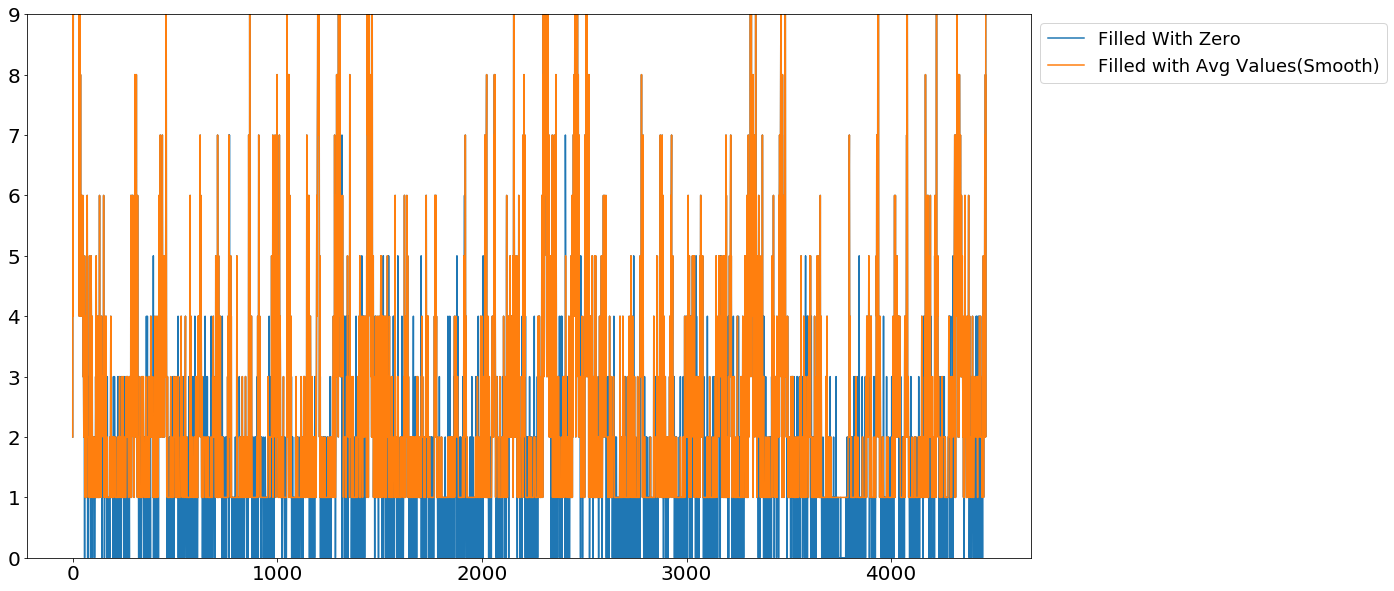

In [232]:
fig = plt.figure(figsize = (18, 10))
plt.plot(jan_2015_fillZero[4464*25:4464*26], label = "Filled With Zero")
plt.plot(jan_2015_fillSmooth[4464*25:4464*26], label = "Filled with Avg Values(Smooth)")
plt.legend(bbox_to_anchor=(1, 1), fontsize = 18)
plt.ylim(0,9)
plt.tick_params(labelsize = 20)
plt.show()

In [44]:
unique_binswithPickup_Jan_2016 = getUniqueBinsWithPickups(jan_2016_data)

In [45]:
jan_2016_fillZero = fillMissingWithZero(jan_2016_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2016)

In [46]:
regionWisePickup_Jan_2016 = []
for i in range(30):
    regionWisePickup_Jan_2016.append(jan_2016_fillZero[4464*i:((4464*i)+4464)])

In [47]:
print(len(regionWisePickup_Jan_2016))
print(len(regionWisePickup_Jan_2016[0]))

30
4464


In [49]:
Ratios_DF = pd.DataFrame()
Ratios_DF["Given"] = jan_2015_fillSmooth
Ratios_DF["Prediction"] = jan_2016_fillZero
Ratios_DF["Ratio"] = Ratios_DF["Prediction"]*1.0/Ratios_DF["Given"]*1.0

In [50]:
Ratios_DF.head()

Given  Prediction     Ratio
0     50          39  0.780000
1    109          88  0.807339
2    147         137  0.931973
3    164         177  1.079268
4    163         163  1.000000

In [51]:
Ratios_DF.shape

(133920, 3)

In [52]:
print("Total Number of zeros in Ratio column = "+str(Ratios_DF["Ratio"].value_counts()[0]))

Total Number of zeros in Ratio column = 3529


In [53]:
print("Total Number of zeros in Prediction column = "+str(Ratios_DF["Prediction"].value_counts()[0]))

Total Number of zeros in Prediction column = 3529


In [54]:
def simple_moving_average_ratios(ratios):
    predicted_ratio = (ratios["Ratio"].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 3
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_ratio_values.append(predicted_ratio)
            predicted_pickup_values.append(int(predicted_ratio_values[i] * ratios["Given"].values[i]))
            absolute_error.append(abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]))
            
            error = math.pow((int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            predicted_ratio = sum(ratios["Ratio"].values[(i+1) - window_size:(i+1)])
            predicted_ratio = predicted_ratio/window_size
        else:
            predicted_ratio = sum(ratios["Ratio"].values[0:(i+1)])
            predicted_ratio = predicted_ratio/(i+1)
            
    ratios["Simple_Moving_Average_Ratios_Pred"] = predicted_pickup_values
    ratios["Simple_Moving_Average_Ratios_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [57]:
def simple_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 2
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            
            error = math.pow((predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            predicted_pickup = sum(ratios["Prediction"].values[(i+1) - window_size:(i+1)])
            predicted_pickup = predicted_pickup/window_size
        else:
            predicted_pickup = sum(ratios["Prediction"].values[0:(i+1)])
            predicted_pickup = predicted_pickup/(i+1)
            
    ratios["Simple_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Simple_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [58]:
def weighted_moving_average_ratios(ratios):
    predicted_ratio = (ratios["Ratio"].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 4
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_ratio_values.append(predicted_ratio)
            predicted_pickup_values.append(int(predicted_ratio_values[i] * ratios["Given"].values[i]))
            absolute_error.append(abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]))
            
            error = math.pow((int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            sumOfRatios = 0
            sumOfWeights = 0
            for j in range(window_size, 0, -1):
                sumOfRatios = sumOfRatios + j*(ratios["Ratio"].values)[i -window_size + j]
                sumOfWeights = sumOfWeights + j
            predicted_ratio = sumOfRatios/sumOfWeights
        else:
            sumOfRatios = 0
            sumOfWeights = 0
            for j in range(i+1, 0, -1):
                sumOfRatios = sumOfRatios + j*(ratios["Ratio"].values)[j-1]
                sumOfWeights = sumOfWeights + j
            predicted_ratio = sumOfRatios/sumOfWeights
    
    ratios["Weighted_Moving_Average_Ratios_Pred"] = predicted_pickup_values
    ratios["Weighted_Moving_Average_Ratios_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [59]:
def weighted_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 2
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            
            error = math.pow(int(predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            sumPickups = 0
            sumOfWeights = 0
            for j in range(window_size, 0, -1):
                sumPickups = sumPickups + j*(ratios["Prediction"].values)[i -window_size + j]
                sumOfWeights = sumOfWeights + j
            predicted_pickup = sumPickups/sumOfWeights
        else:
            sumPickups = 0
            sumOfWeights = 0
            for j in range(i+1, 0, -1):
                sumPickups += j*(ratios["Prediction"].values)[j-1]
                sumOfWeights += j
            predicted_pickup = sumPickups/sumOfWeights
    
    ratios["Weighted_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Weighted_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [60]:
def exponential_weighted_moving_average_ratios(ratios):
    predicted_ratio = (ratios["Ratio"].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    alpha = 0.5
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_ratio_values.append(predicted_ratio)
            predicted_pickup_values.append(int(predicted_ratio_values[i] * ratios["Given"].values[i]))
            absolute_error.append(abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]))
            error = math.pow((int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            predicted_ratio = alpha*predicted_ratio + ((1-alpha)*ratios["Ratio"].values[i-1])
            
            
    ratios["Exponential_Weighted_Moving_Average_Ratios_Pred"] = predicted_pickup_values
    ratios["Exponential_Weighted_Moving_Average_Ratios_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [61]:
def exponential_weighted_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    alpha = 0.5
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            error = math.pow((predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            predicted_pickup = alpha*predicted_pickup + ((1-alpha)*ratios["Prediction"].values[i-1])
            
            
    ratios["Exponential_Weighted_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Exponential_Weighted_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [62]:
r1, mape1, mse1 = simple_moving_average_ratios(Ratios_DF)
r2, mape2, mse2 = simple_moving_average_predictions(Ratios_DF)
r3, mape3, mse3 = weighted_moving_average_ratios(Ratios_DF)
r4, mape4, mse4 = weighted_moving_average_predictions(Ratios_DF)
r5, mape5, mse5 = exponential_weighted_moving_average_ratios(Ratios_DF)
r6, mape6, mse6 = exponential_weighted_moving_average_predictions(Ratios_DF)

In [63]:
error_table_baseline = pd.DataFrame(columns = ["Model", "MAPE(%)", "MSE"])

error_table_baseline = error_table_baseline.append(pd.DataFrame([["Simple Moving Average Ratios", mape1*100, mse1]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Simple Moving Average Predictions", mape2*100, mse2]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Weighted Moving Average Ratios", mape3*100, mse3]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Weighted Moving Average Predictions", mape4*100, mse4]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Exponential Weighted Moving Average Ratios", mape5*100, mse5]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Exponential Weighted Moving Average Predictions", mape6*100, mse6]], columns = ["Model", "MAPE(%)", "MSE"]))

error_table_baseline.reset_index(drop = True, inplace = True)

In [64]:
error_table_baseline.style.highlight_min(axis=0)

In [65]:
number_of_time_stamps = 5
TruePickups = []
lat = []
lon = []
day_of_week = []
feat = []


centerOfRegions = regions.cluster_centers_
feat = [0]*number_of_time_stamps
for i in range(30):
    lat.append([centerOfRegions[i][0]]*4459) 
    lon.append([centerOfRegions[i][1]]*4459)
    day_of_week.append([int(((int(j/144)%7)+5)%7) for j in range(5, 4464)])
    feat = np.vstack((feat, [regionWisePickup_Jan_2016[i][k:k+number_of_time_stamps] for k in range(0, len(regionWisePickup_Jan_2016[i]) - (number_of_time_stamps))]))
    TruePickups.append(regionWisePickup_Jan_2016[i][5:])
feat = feat[1:]

In [67]:
len(lat[0])*len(lat) == len(lon[0])*len(lon) == len(day_of_week[0])*len(day_of_week) == 4459*30 == len(feat) == len(TruePickups[0])*len(TruePickups)

True

In [68]:
feat

array([[ 39,  88, 137, 177, 163],
       [ 88, 137, 177, 163, 175],
       [137, 177, 163, 175, 181],
       ...,
       [ 80,  70,  73,  78,  61],
       [ 70,  73,  78,  61,  72],
       [ 73,  78,  61,  72,  53]], dtype=int64)

In [69]:
predicted_pickup_values = []

predicted_pickup_values_list = []

predicted_value = -1  
window_size = 2
for i in range(30):
    for j in range(4464):
        if j == 0:
            predicted_value = regionWisePickup_Jan_2016[i][j]
            predicted_pickup_values.append(0)
        else:
            if j>=window_size:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(window_size, 0, -1):
                    sumPickups += k*(regionWisePickup_Jan_2016[i][j -window_size + (k - 1)])
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
            else:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(j, 0, -1):
                    sumPickups += k*regionWisePickup_Jan_2016[i][k-1]
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
                
    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [70]:
len(predicted_pickup_values_list[0])*len(predicted_pickup_values_list) == 4459*30

True

<IPython.core.display.Javascript object>


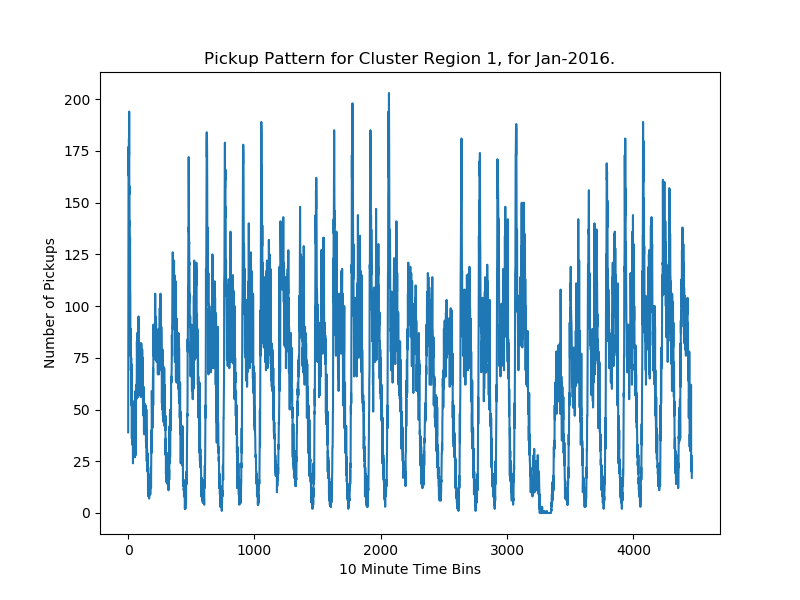

<IPython.core.display.Javascript object>


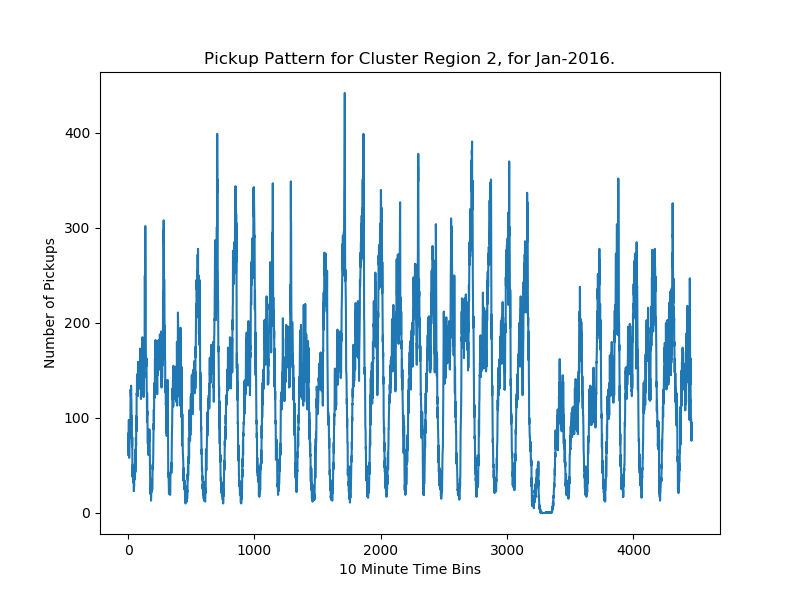

<IPython.core.display.Javascript object>


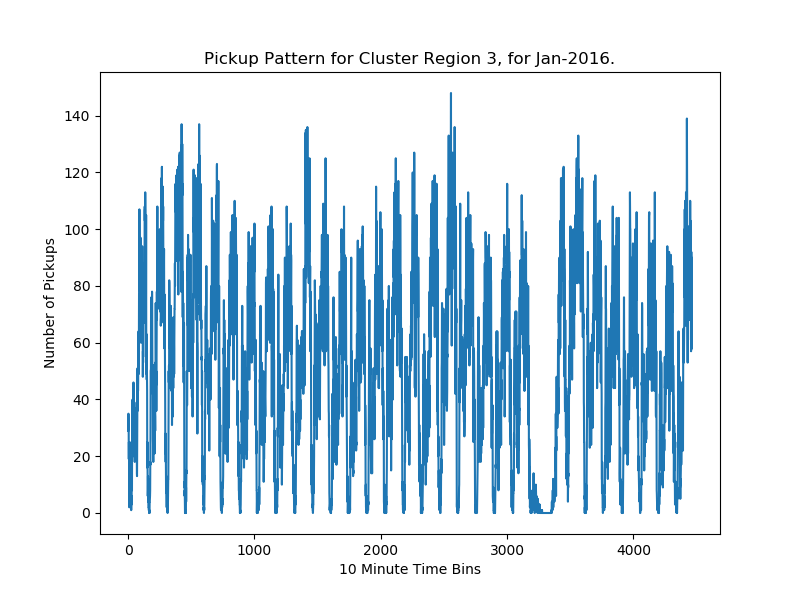

<IPython.core.display.Javascript object>


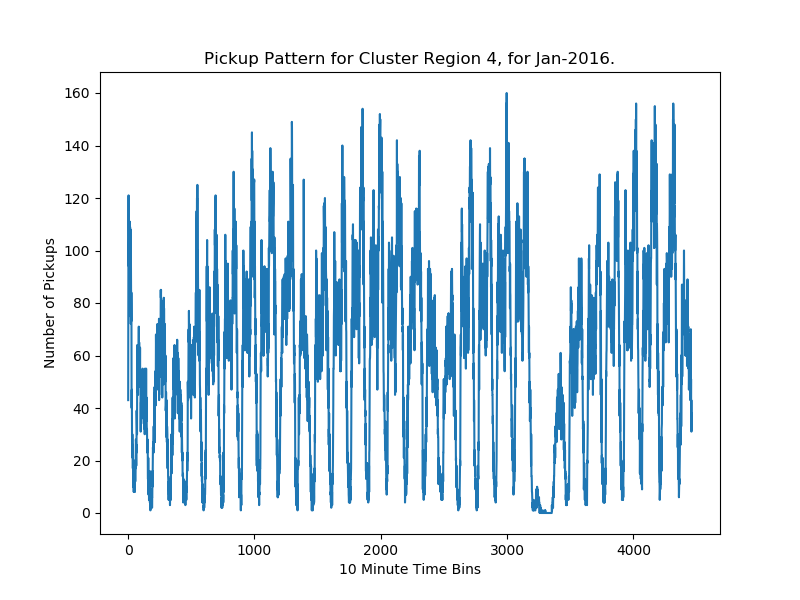

<IPython.core.display.Javascript object>


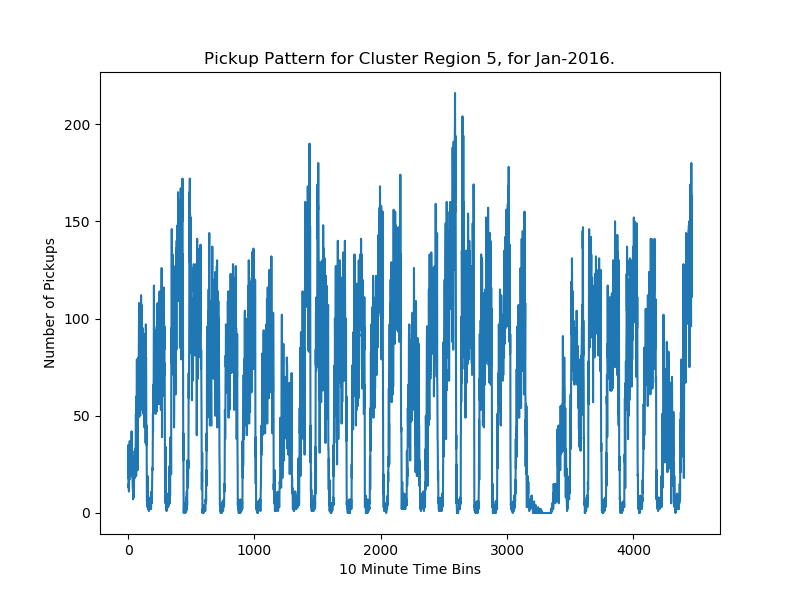

<IPython.core.display.Javascript object>


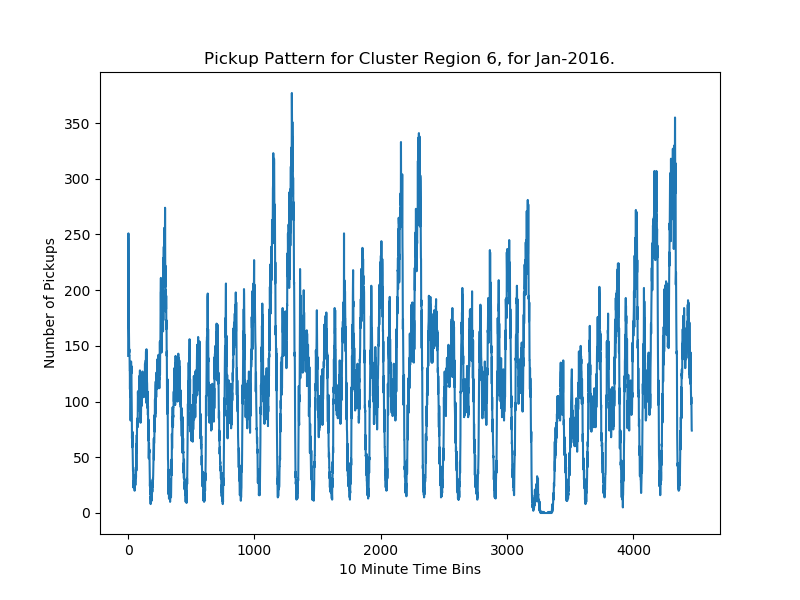

<IPython.core.display.Javascript object>


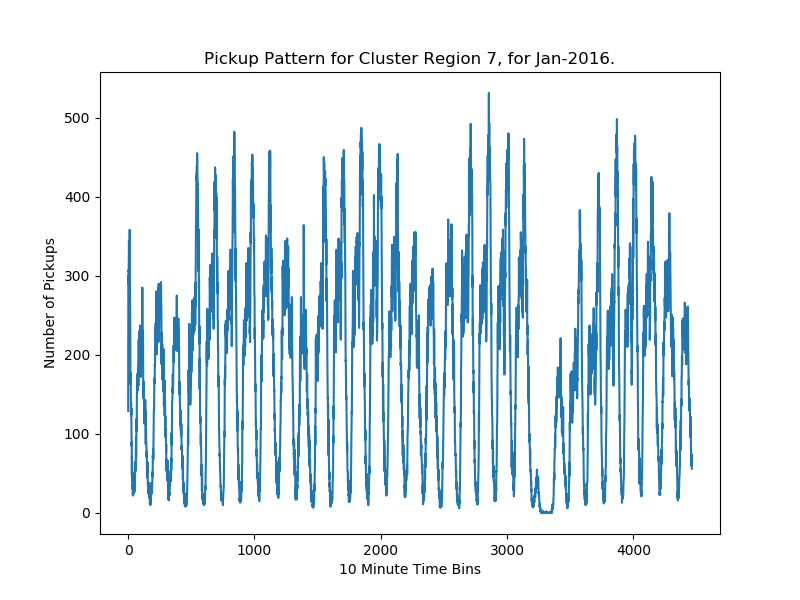

<IPython.core.display.Javascript object>


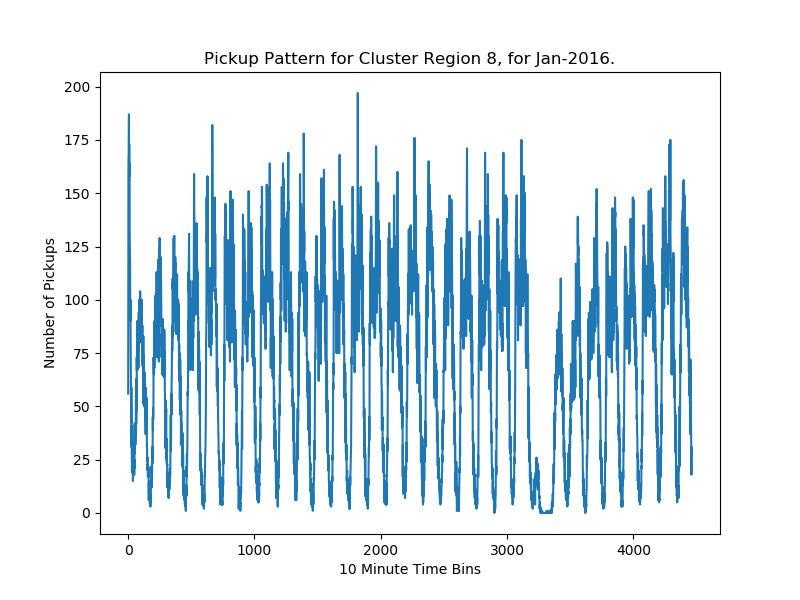

<IPython.core.display.Javascript object>


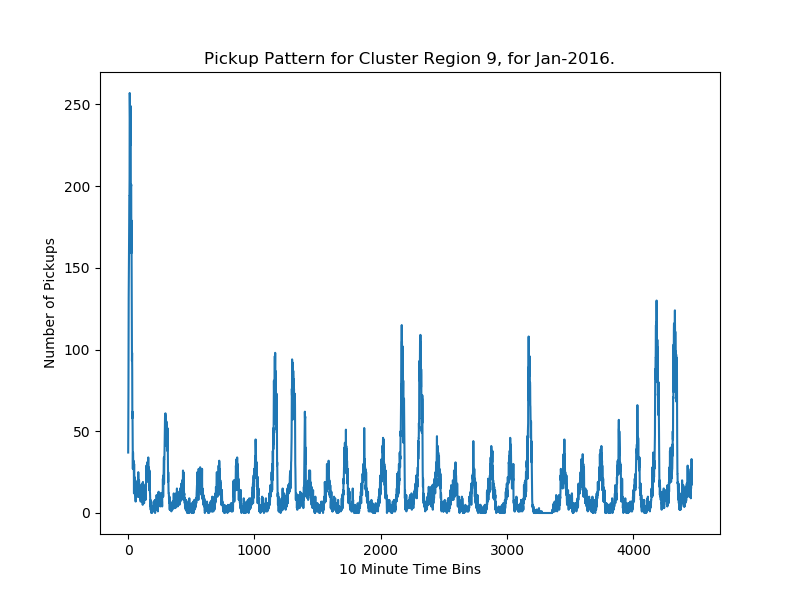

<IPython.core.display.Javascript object>


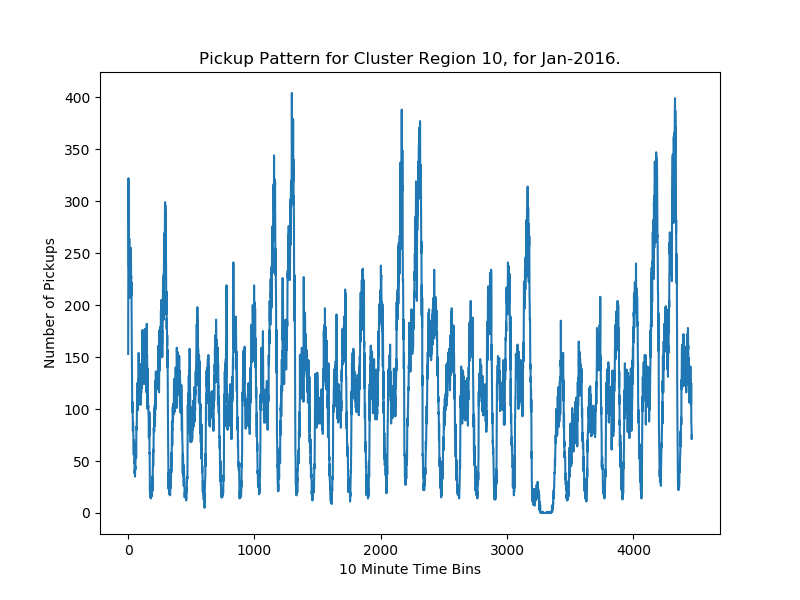

<IPython.core.display.Javascript object>


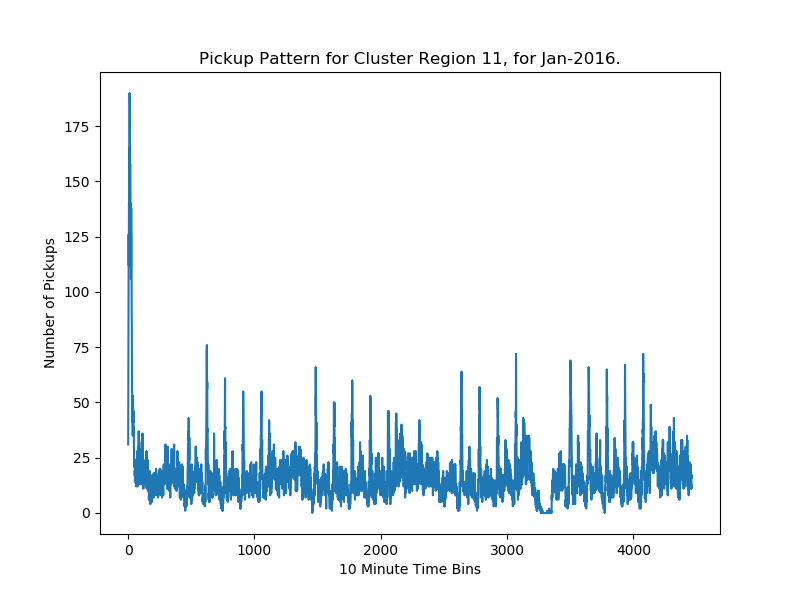

<IPython.core.display.Javascript object>


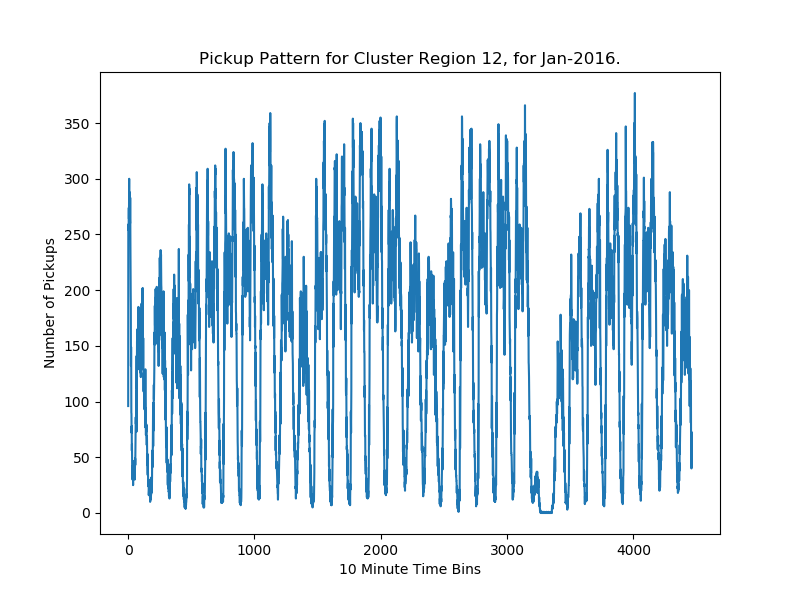

<IPython.core.display.Javascript object>


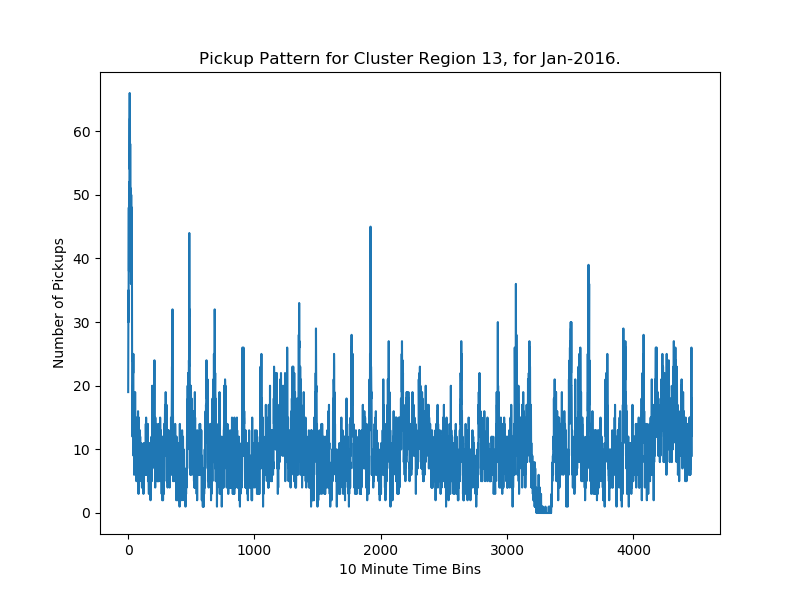

<IPython.core.display.Javascript object>


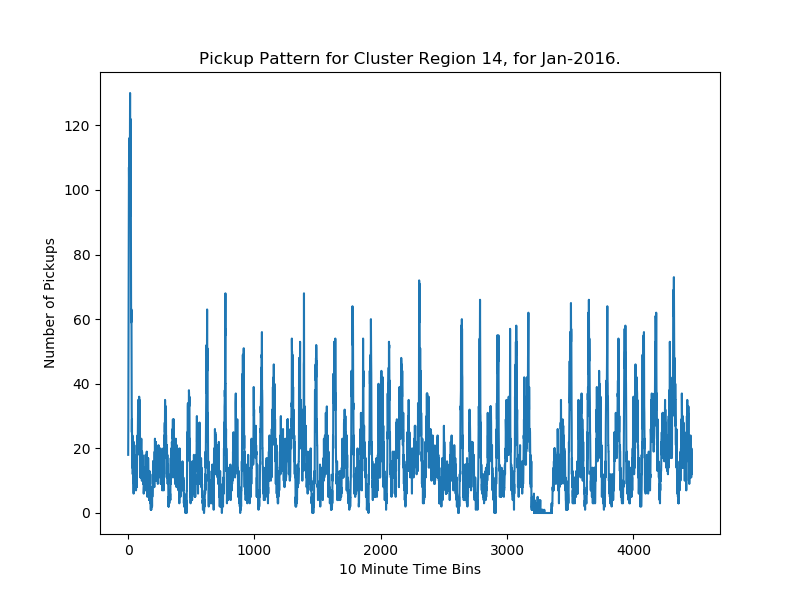

<IPython.core.display.Javascript object>


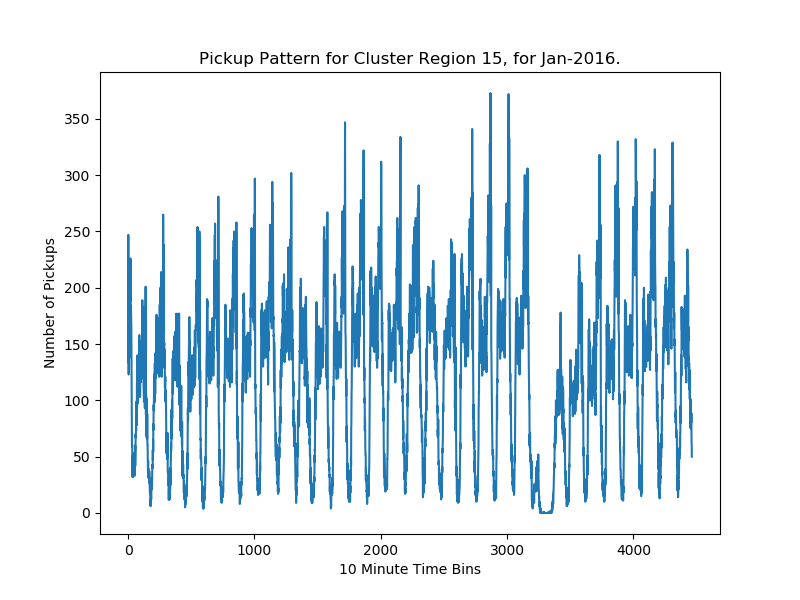

<IPython.core.display.Javascript object>


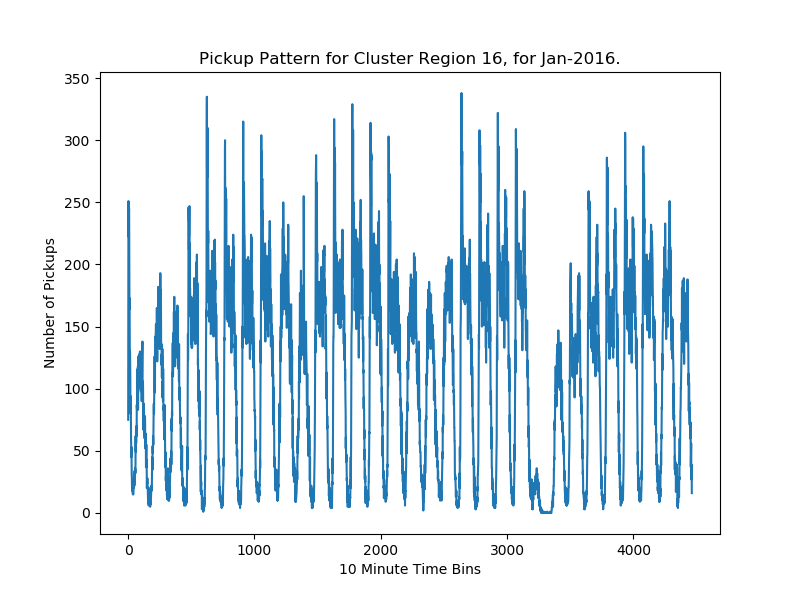

<IPython.core.display.Javascript object>


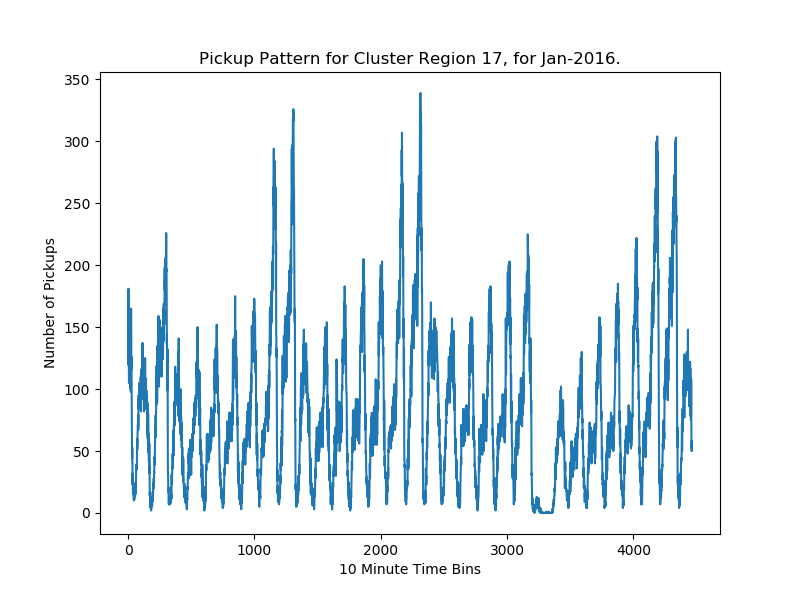

<IPython.core.display.Javascript object>


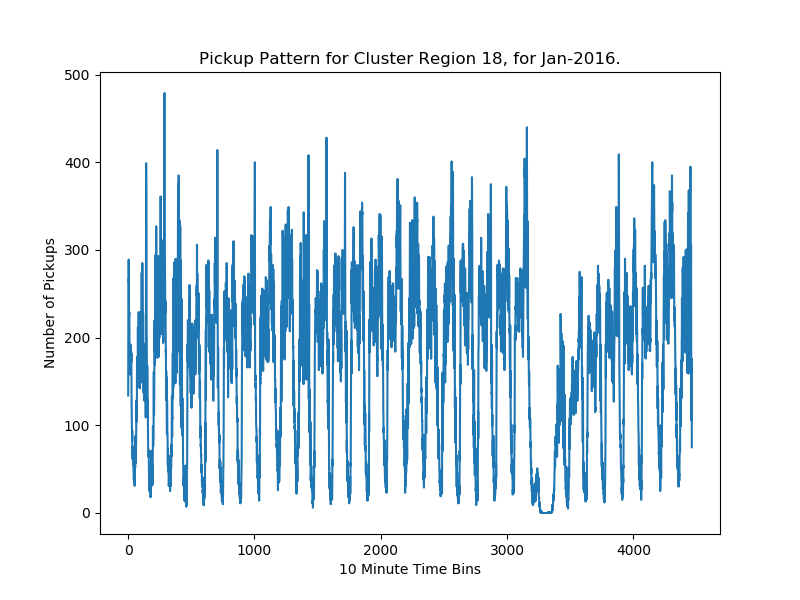

<IPython.core.display.Javascript object>


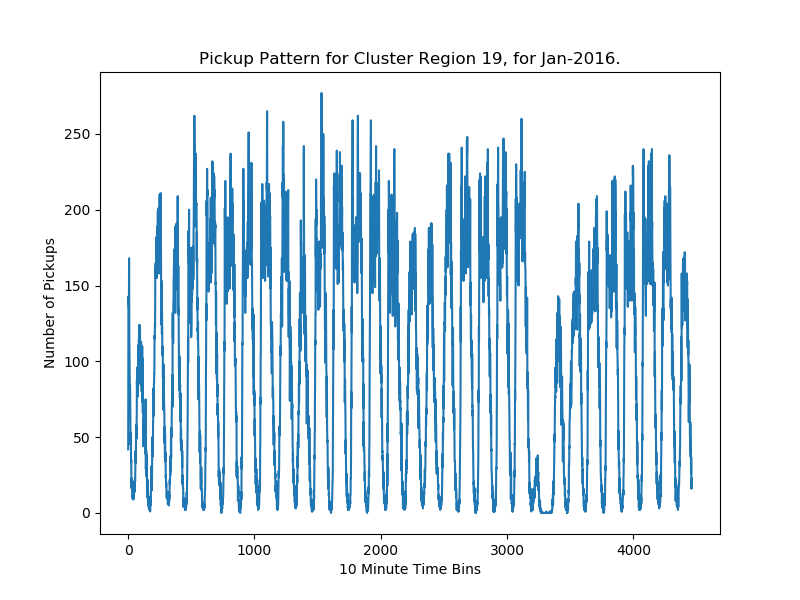

<IPython.core.display.Javascript object>


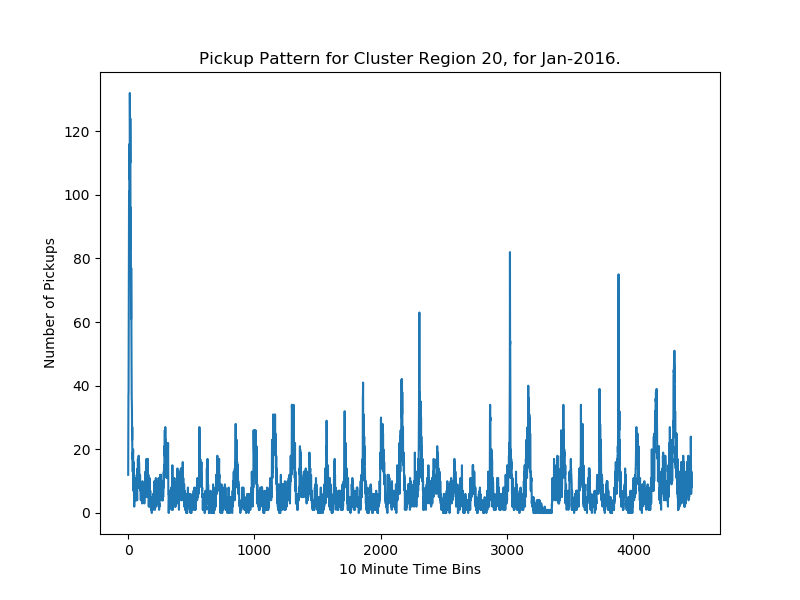

<IPython.core.display.Javascript object>


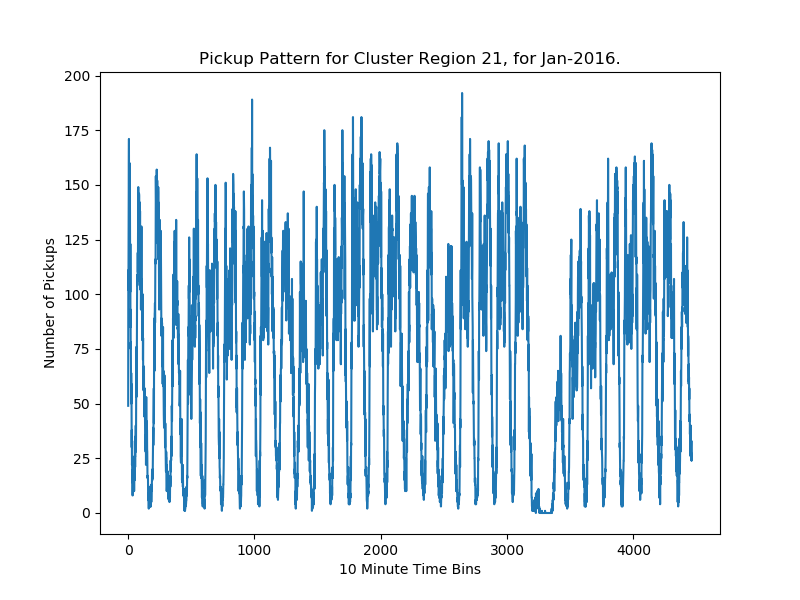

<IPython.core.display.Javascript object>


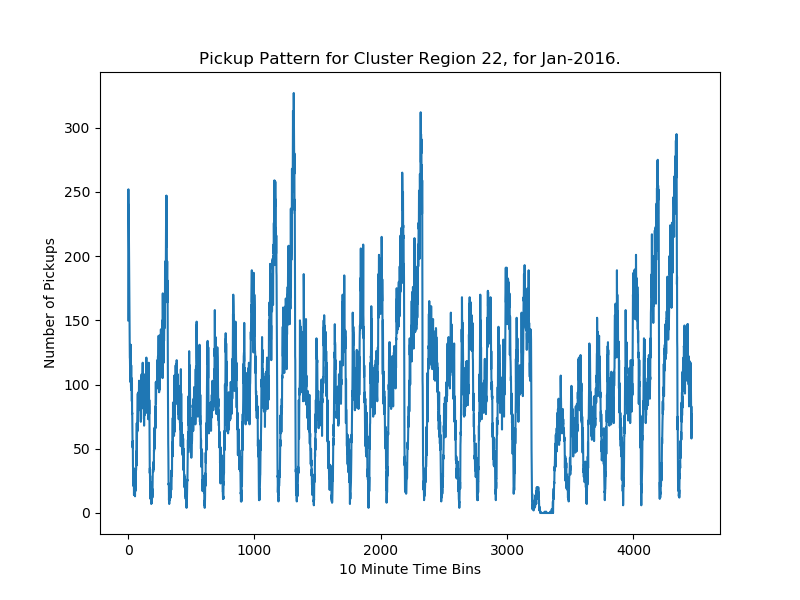

<IPython.core.display.Javascript object>


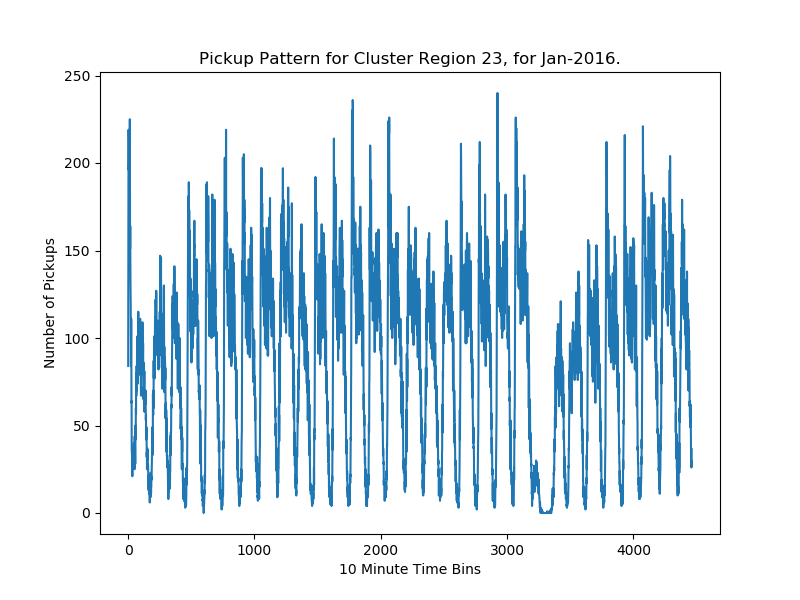

<IPython.core.display.Javascript object>


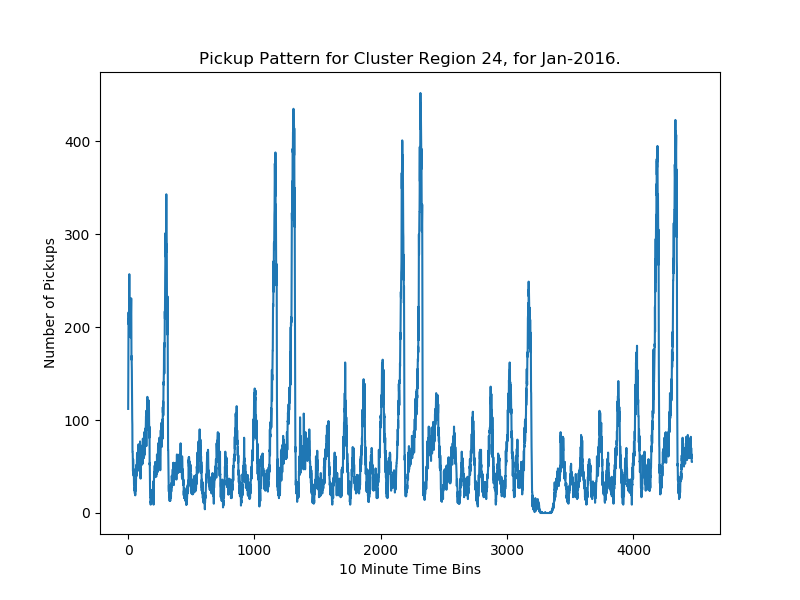

<IPython.core.display.Javascript object>


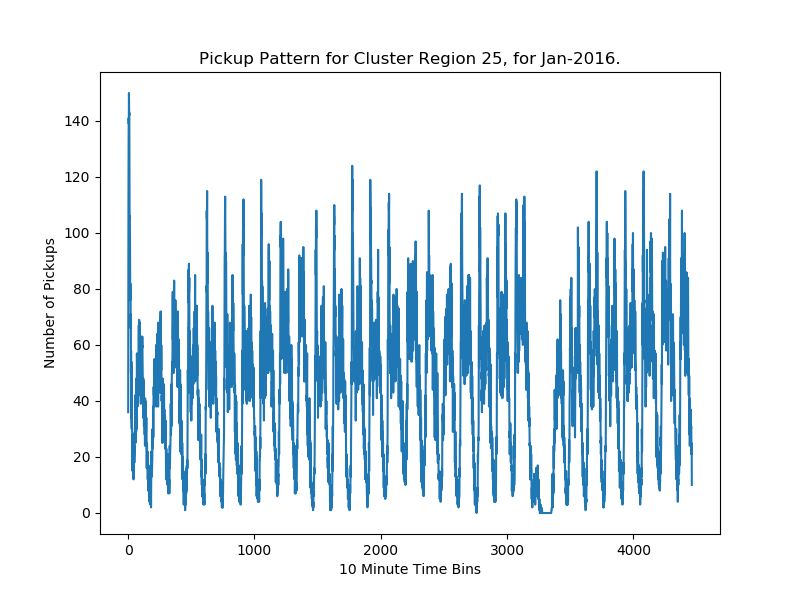

<IPython.core.display.Javascript object>


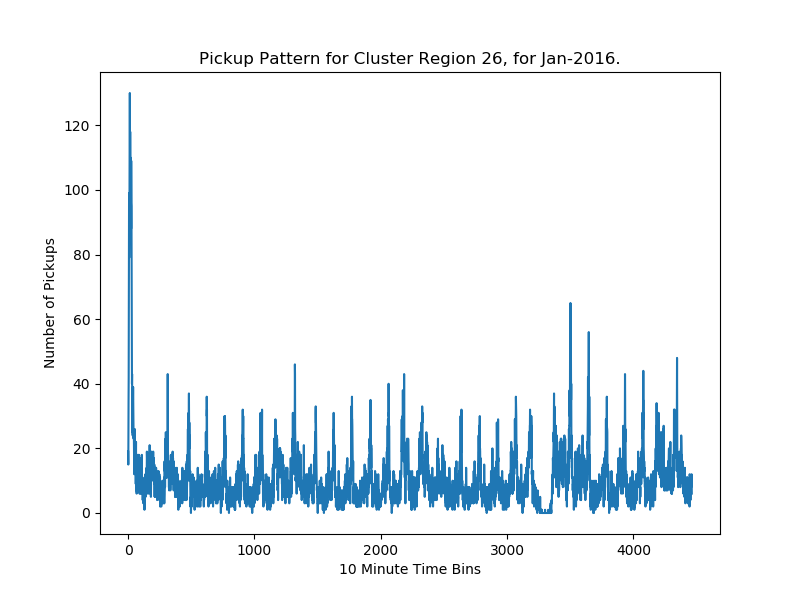

<IPython.core.display.Javascript object>


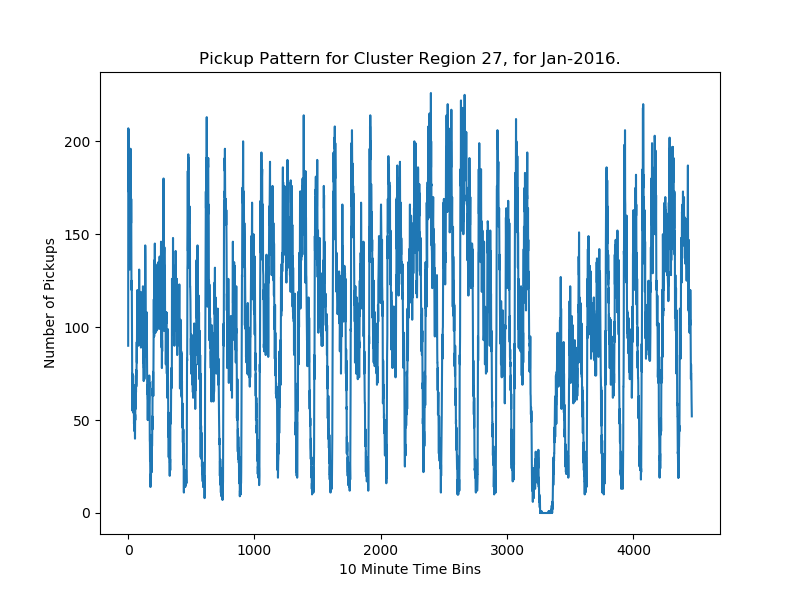

<IPython.core.display.Javascript object>


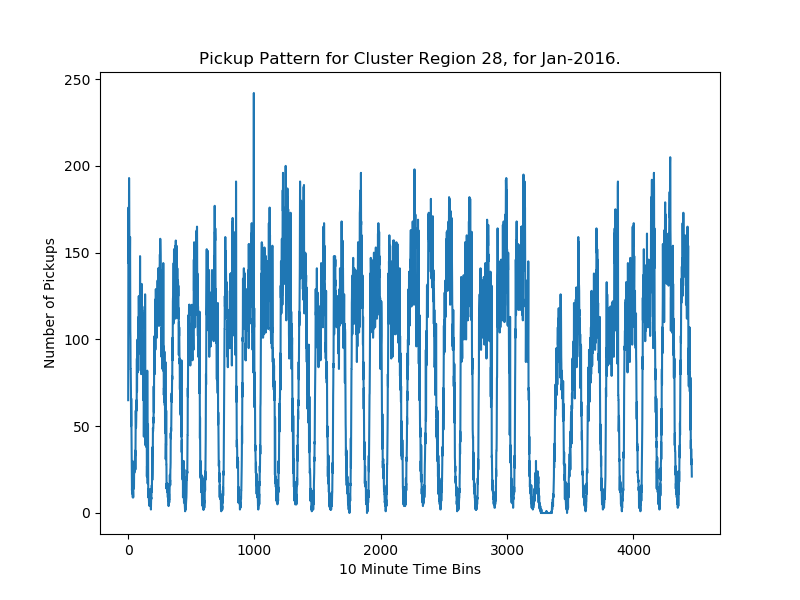

<IPython.core.display.Javascript object>


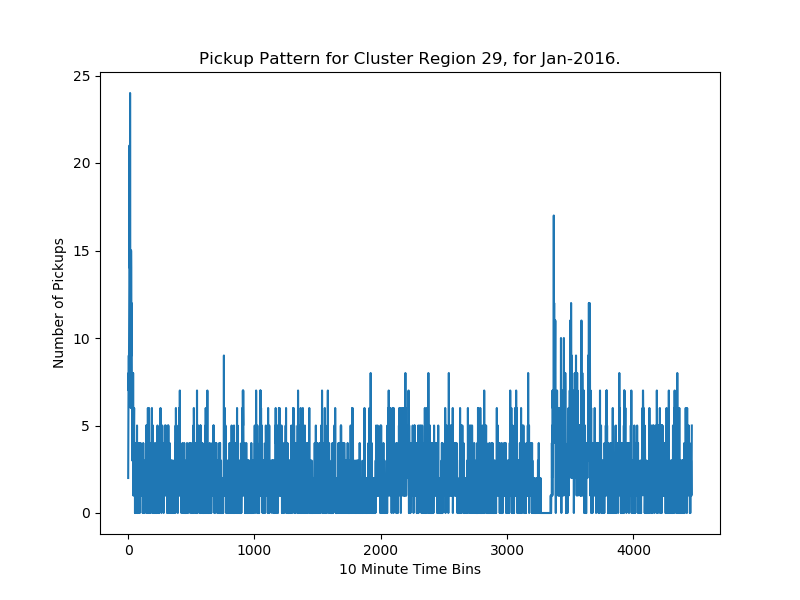

<IPython.core.display.Javascript object>


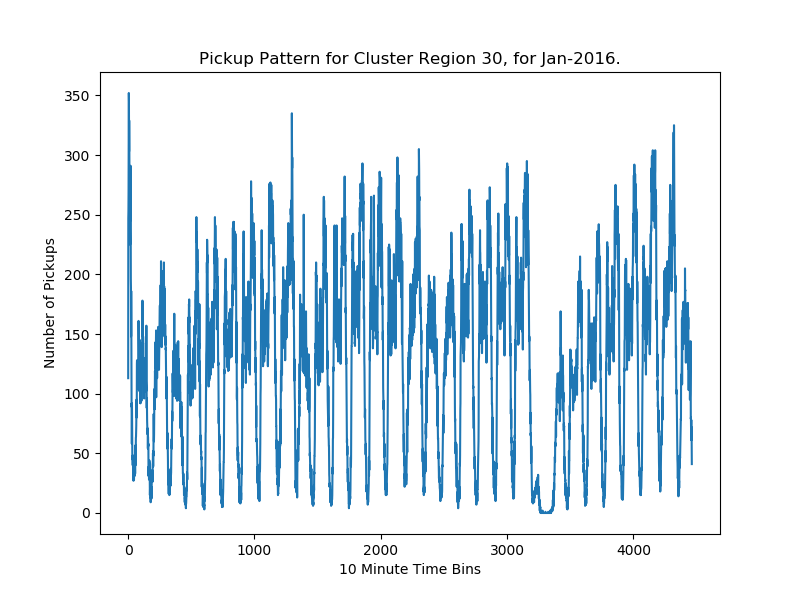

In [71]:
%matplotlib notebook
for i in range(30):
    fig = plt.figure(figsize = (8, 6))
    plt.plot(regionWisePickup_Jan_2016[i][:4464])
    plt.title("Pickup Pattern for Cluster Region "+str(i+1)+", for Jan-2016.")
    plt.xlabel("10 Minute Time Bins")
    plt.ylabel("Number of Pickups")

<b>From the above graphs of pickups of each cluster we can observe that there is a repeating pattern in pickups in 24hrs time period. Now we can decompose these repeating waves by using fourier transform and use their frequencies and their corresponding amplitudes as features in our data.</b>

<IPython.core.display.Javascript object>


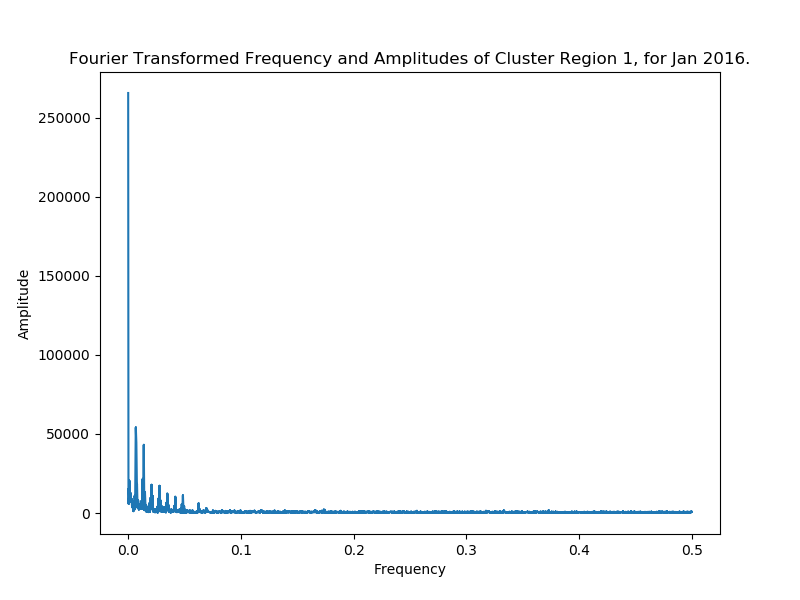

<IPython.core.display.Javascript object>


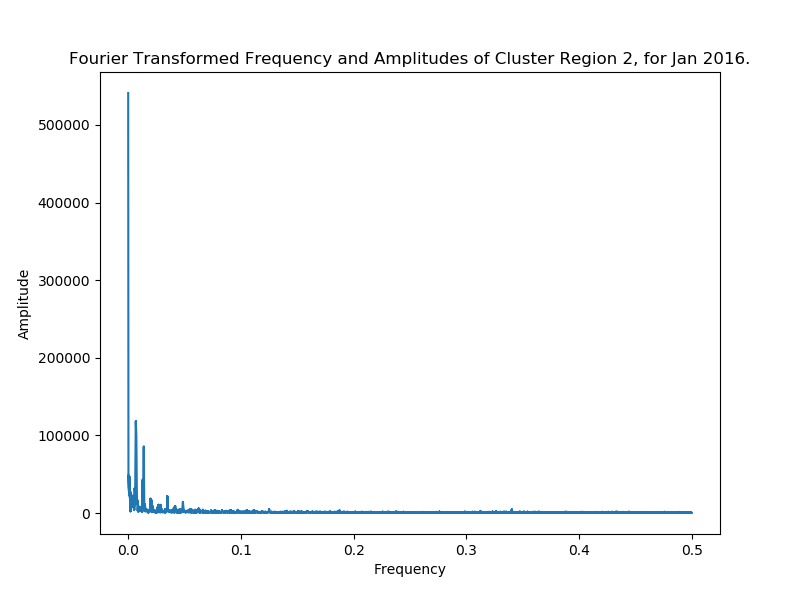

<IPython.core.display.Javascript object>


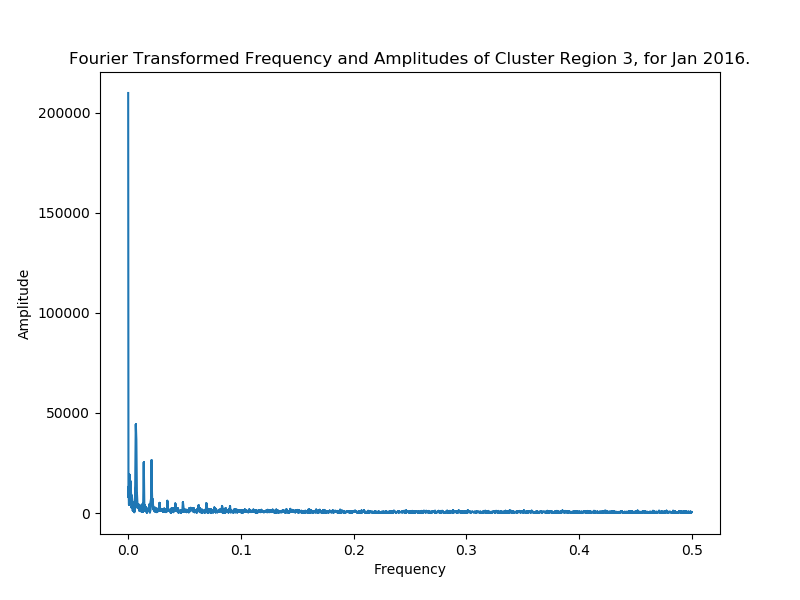

<IPython.core.display.Javascript object>


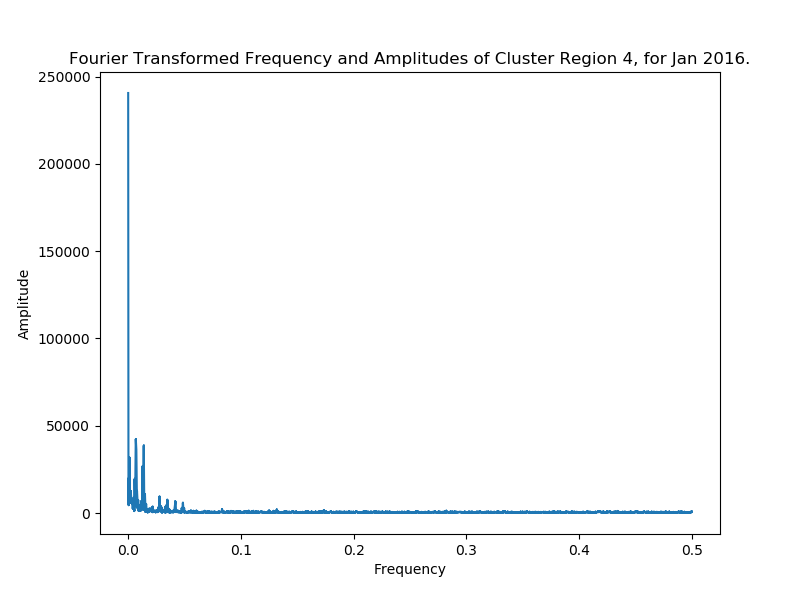

<IPython.core.display.Javascript object>


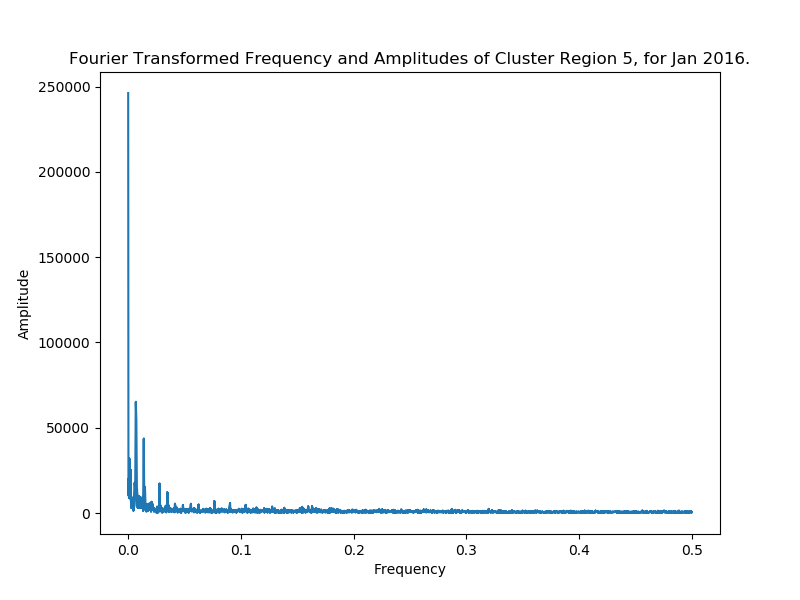

<IPython.core.display.Javascript object>


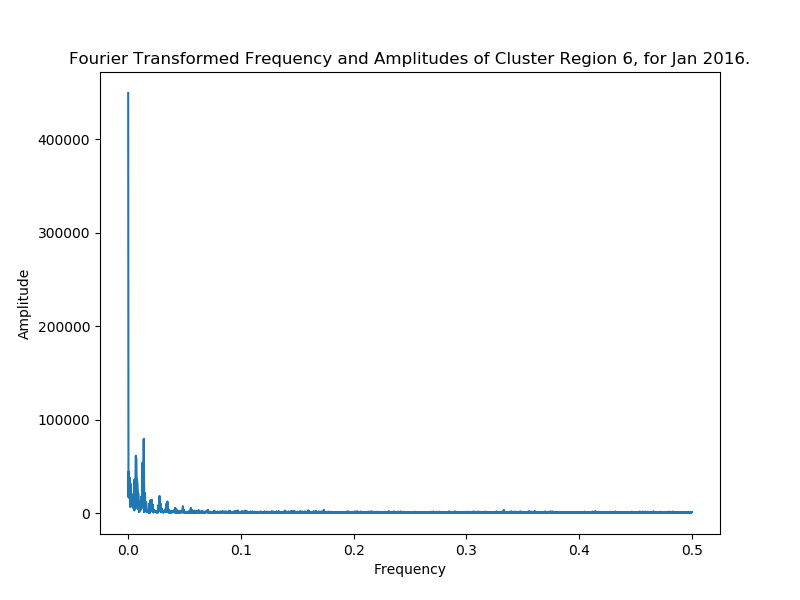

<IPython.core.display.Javascript object>


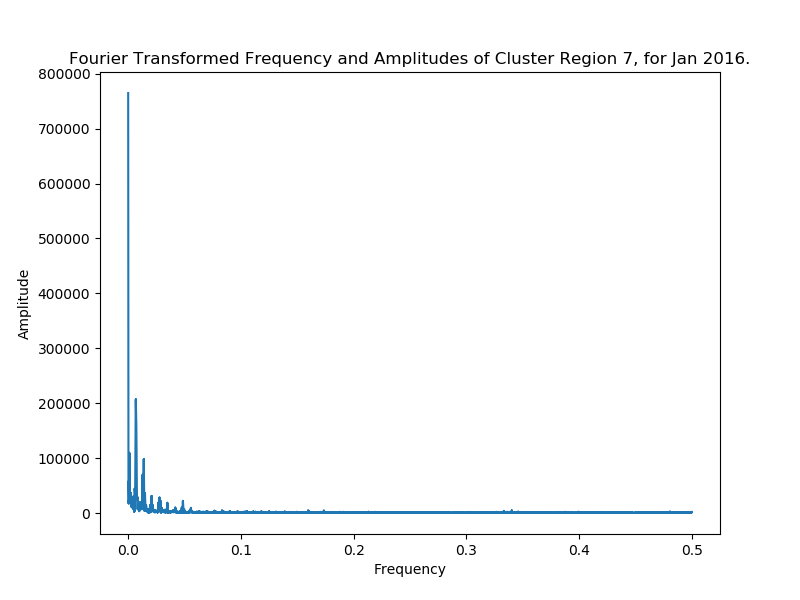

<IPython.core.display.Javascript object>


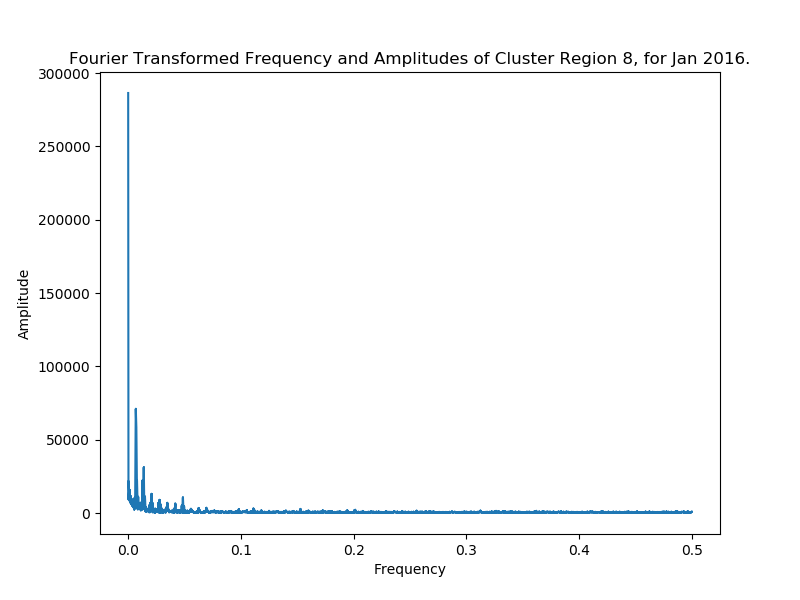

<IPython.core.display.Javascript object>


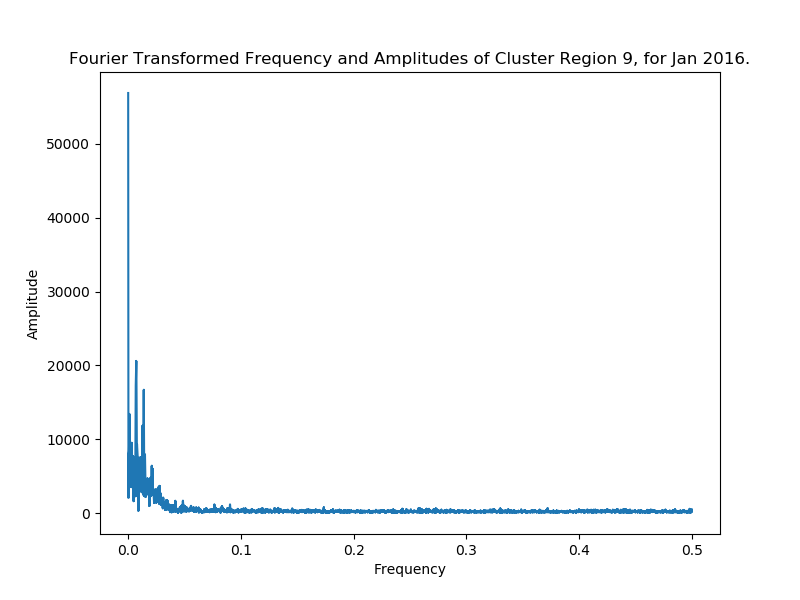

<IPython.core.display.Javascript object>


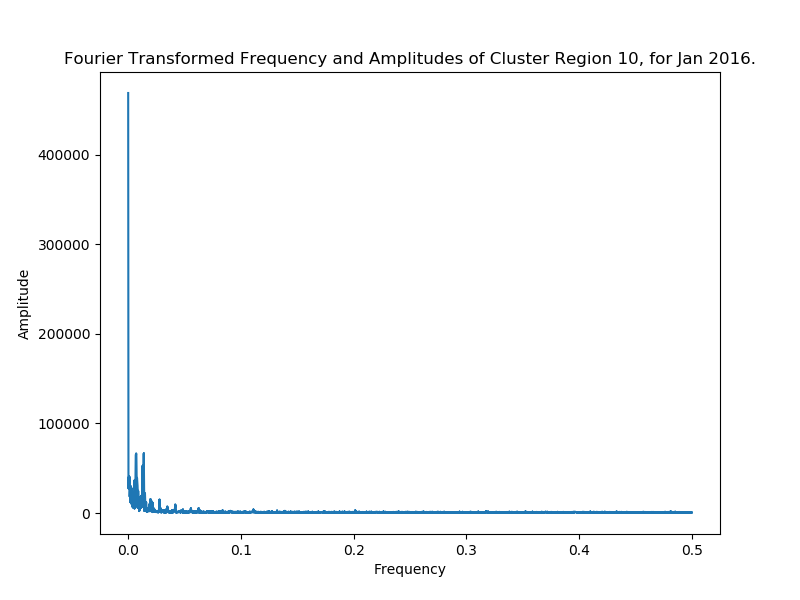

<IPython.core.display.Javascript object>


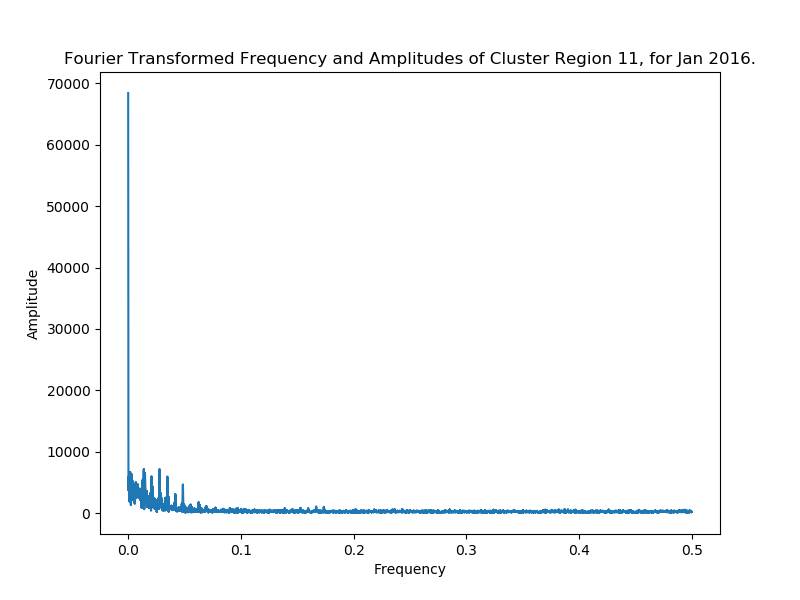

<IPython.core.display.Javascript object>


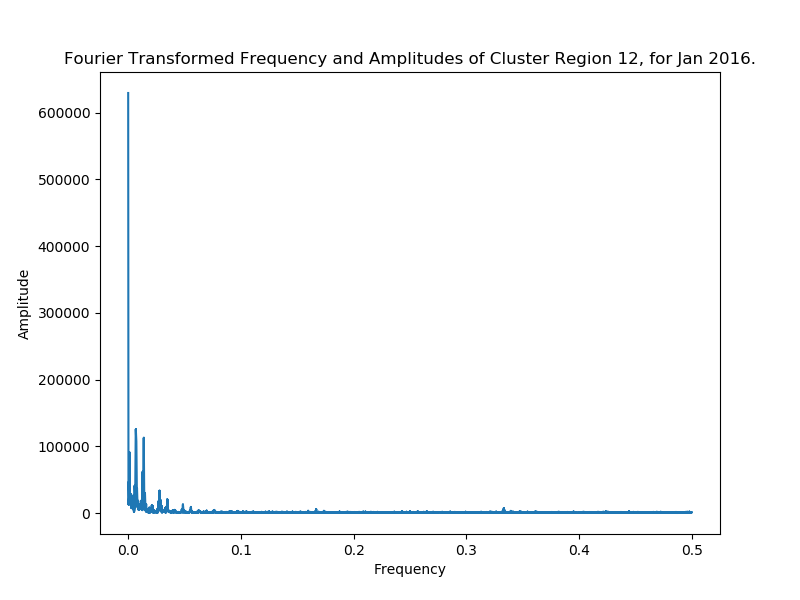

<IPython.core.display.Javascript object>


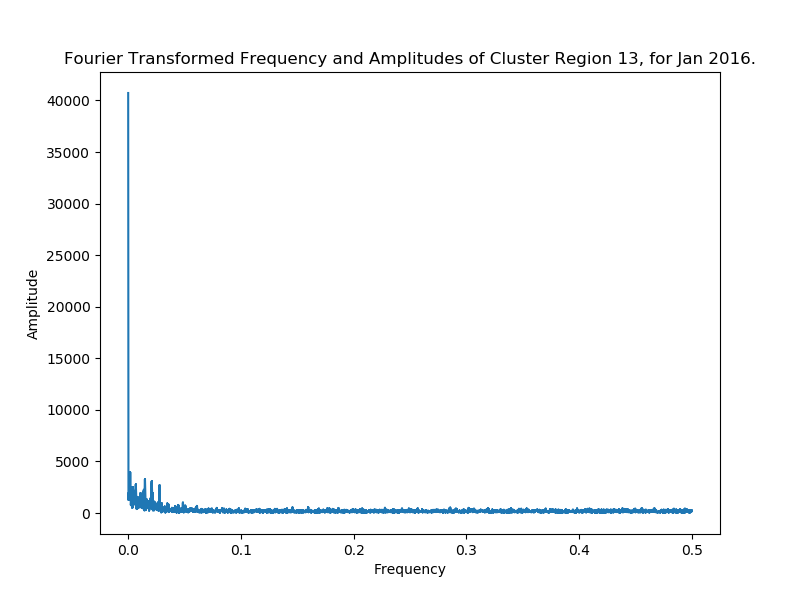

<IPython.core.display.Javascript object>


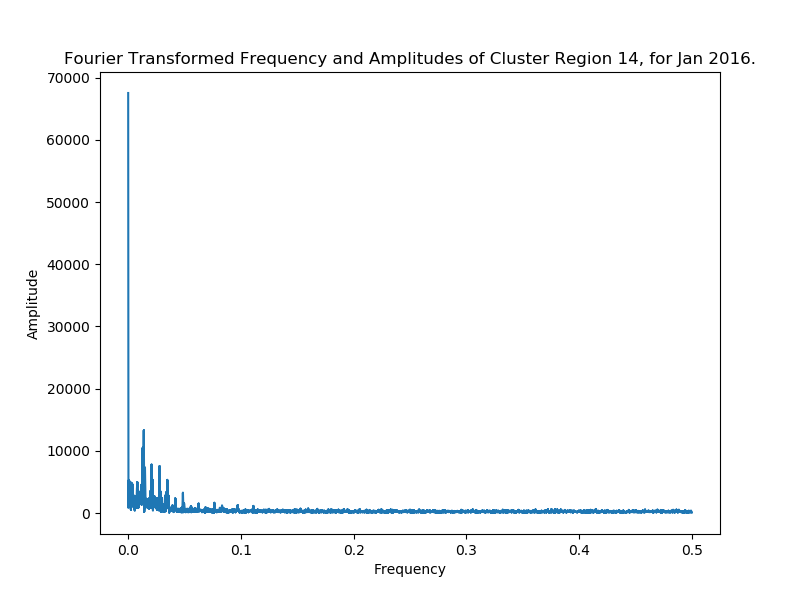

<IPython.core.display.Javascript object>


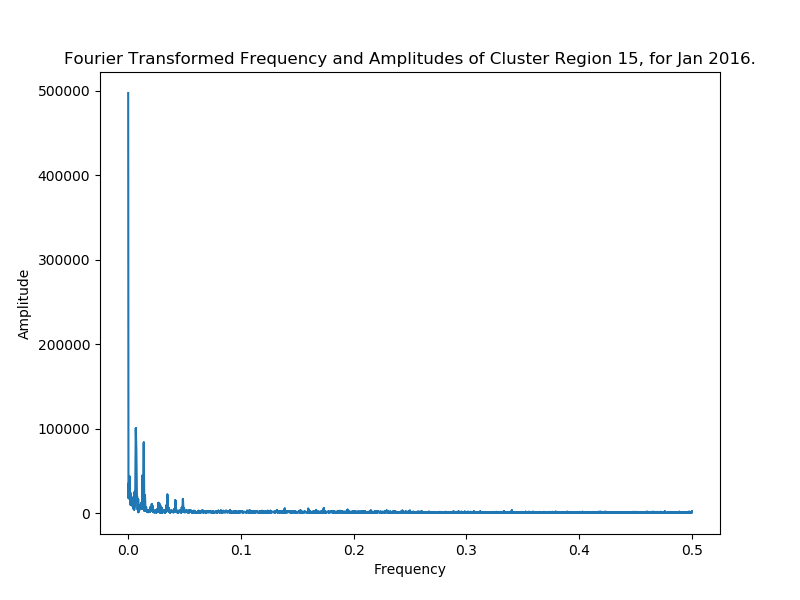

<IPython.core.display.Javascript object>


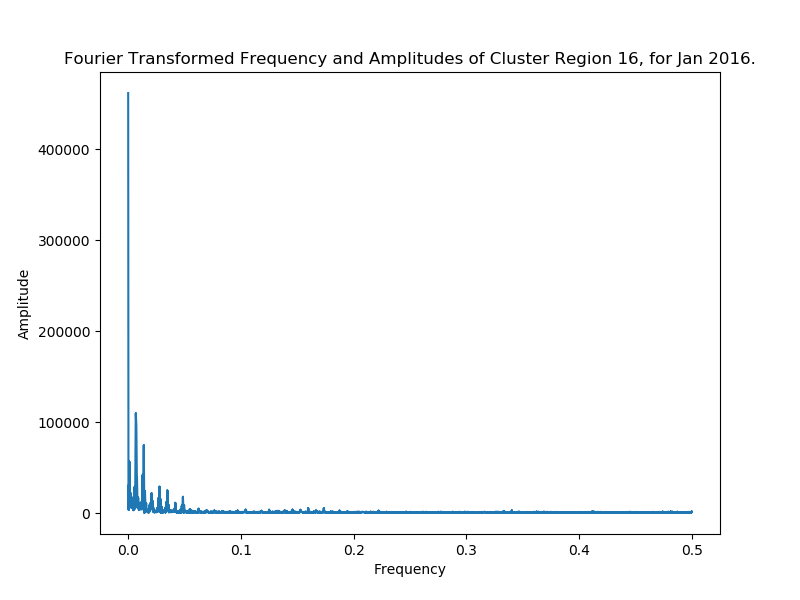

<IPython.core.display.Javascript object>


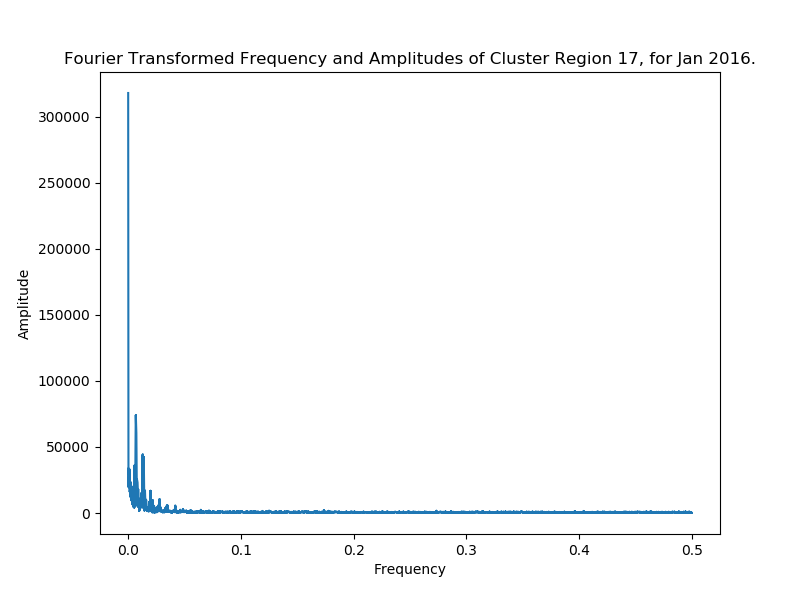

<IPython.core.display.Javascript object>


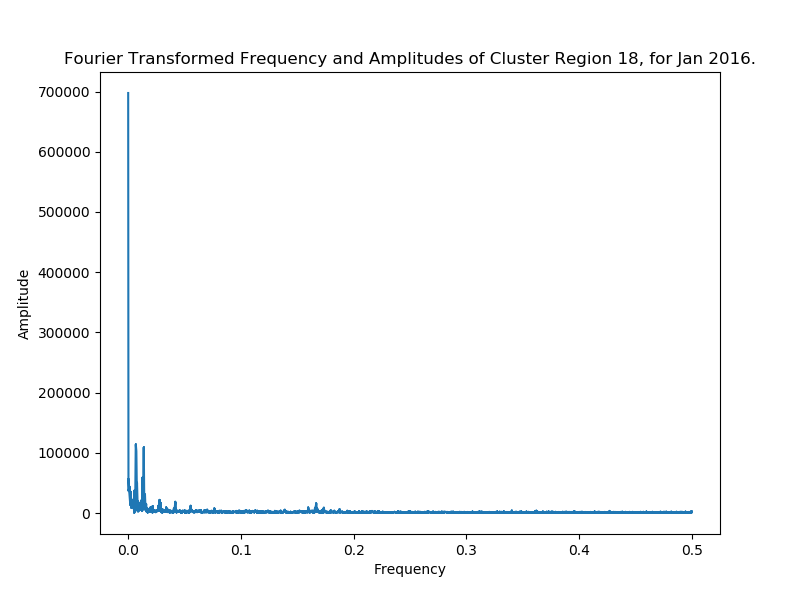

<IPython.core.display.Javascript object>


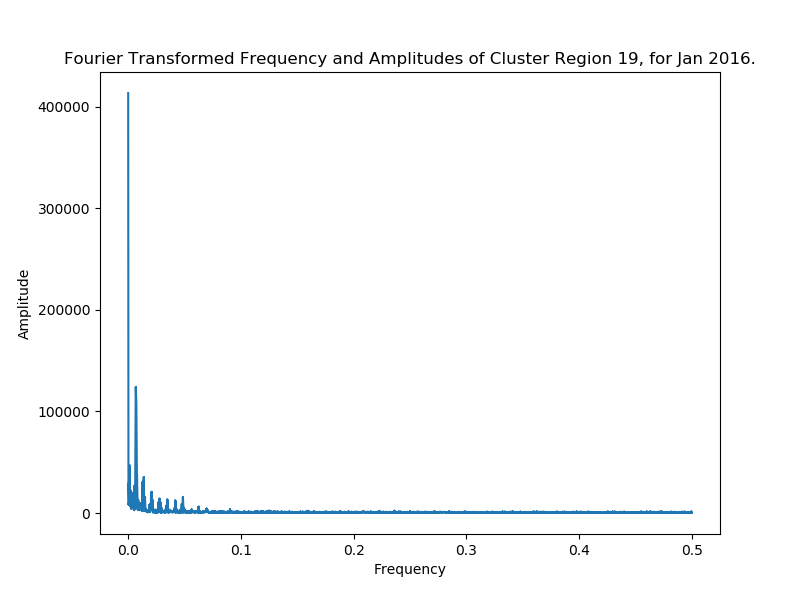

<IPython.core.display.Javascript object>


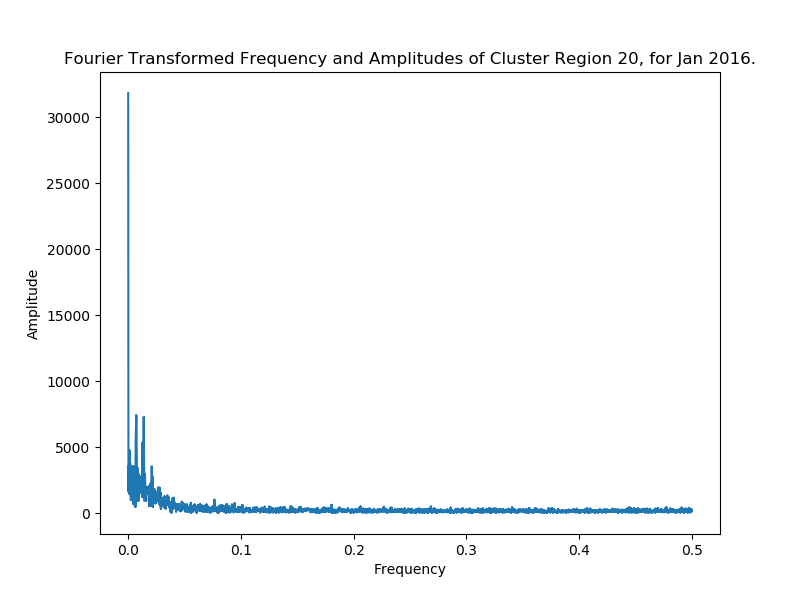

<IPython.core.display.Javascript object>


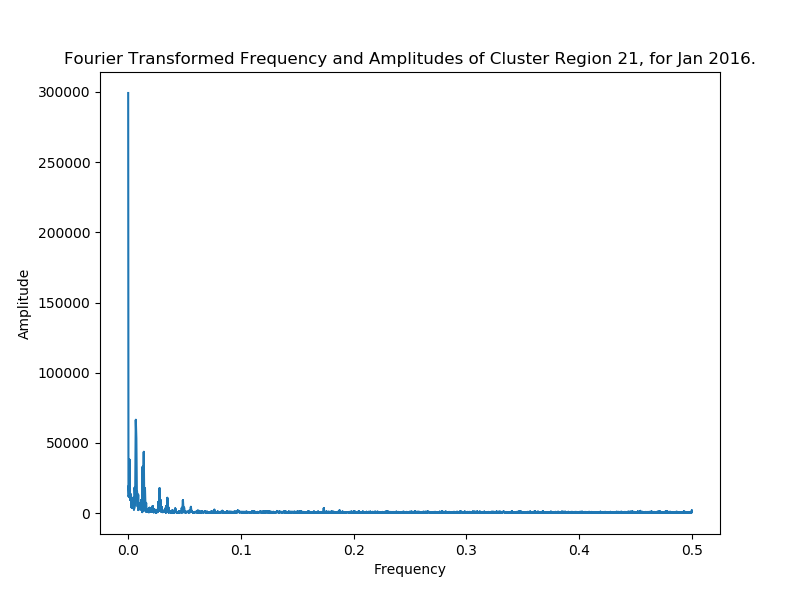

<IPython.core.display.Javascript object>


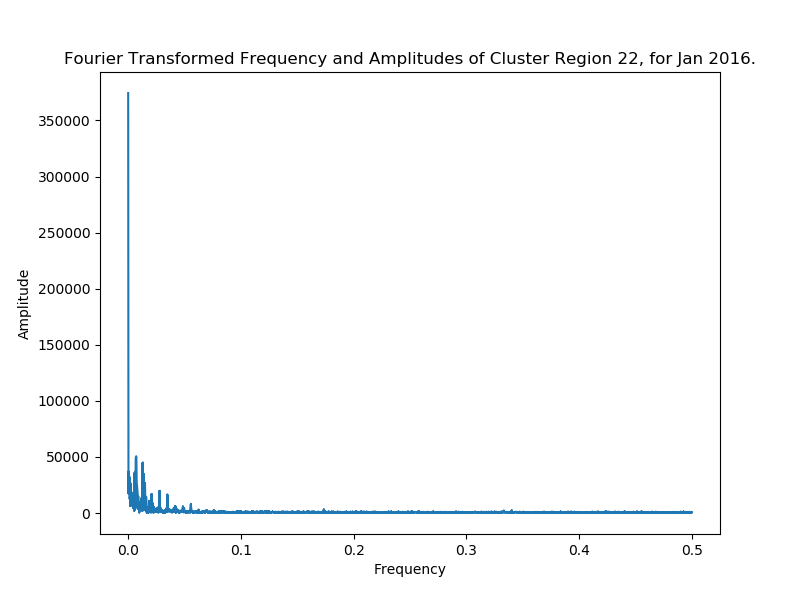

<IPython.core.display.Javascript object>


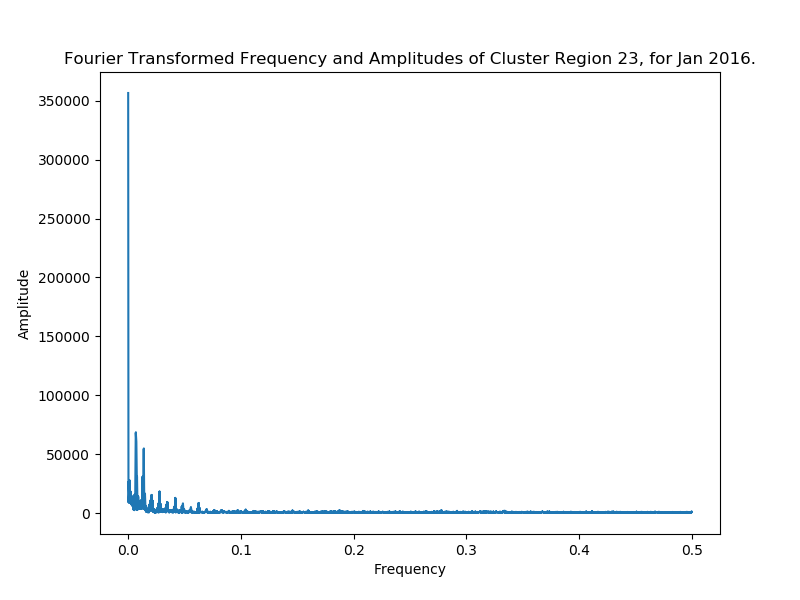

<IPython.core.display.Javascript object>


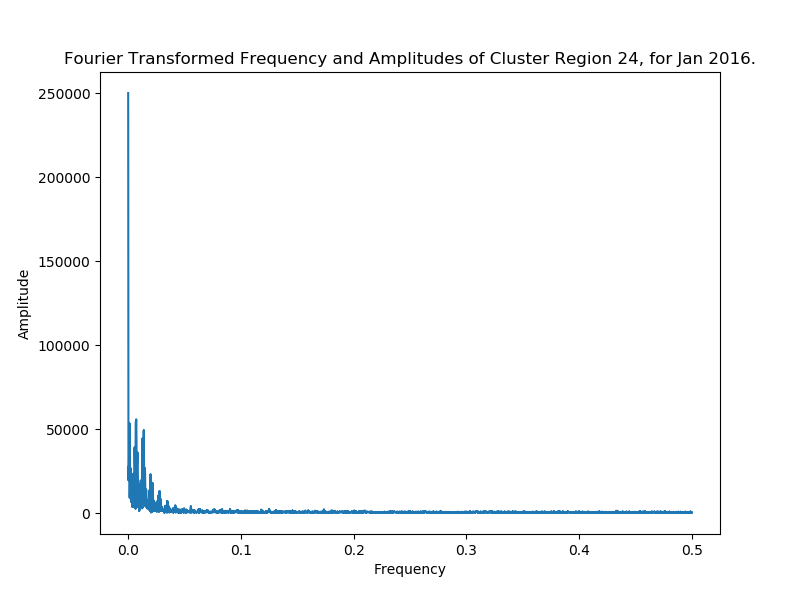

<IPython.core.display.Javascript object>


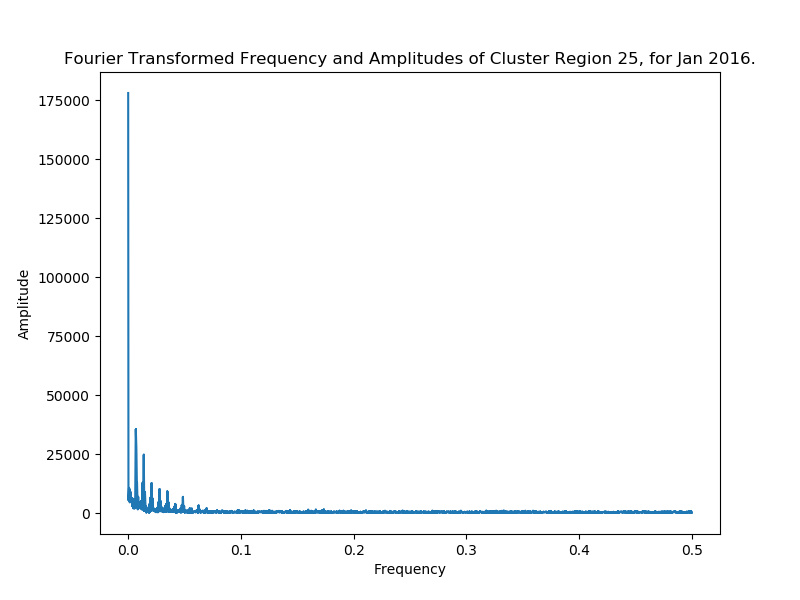

<IPython.core.display.Javascript object>


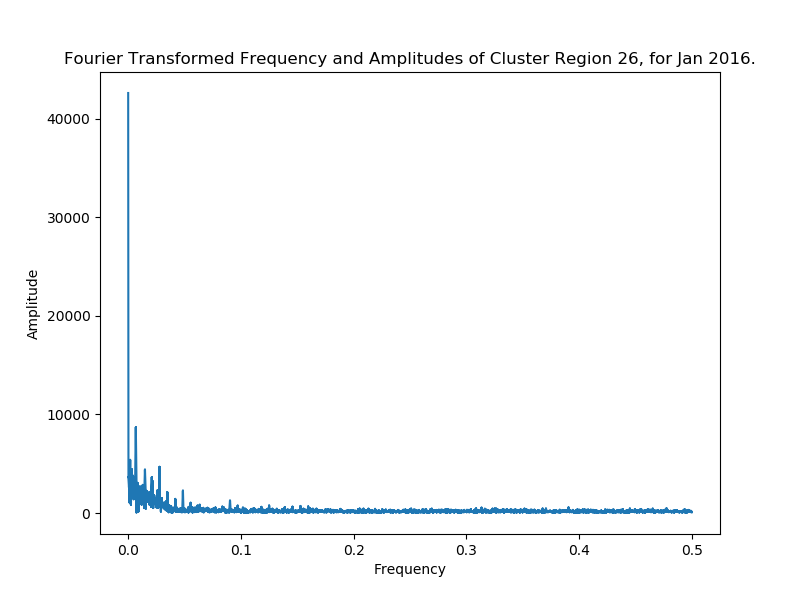

<IPython.core.display.Javascript object>


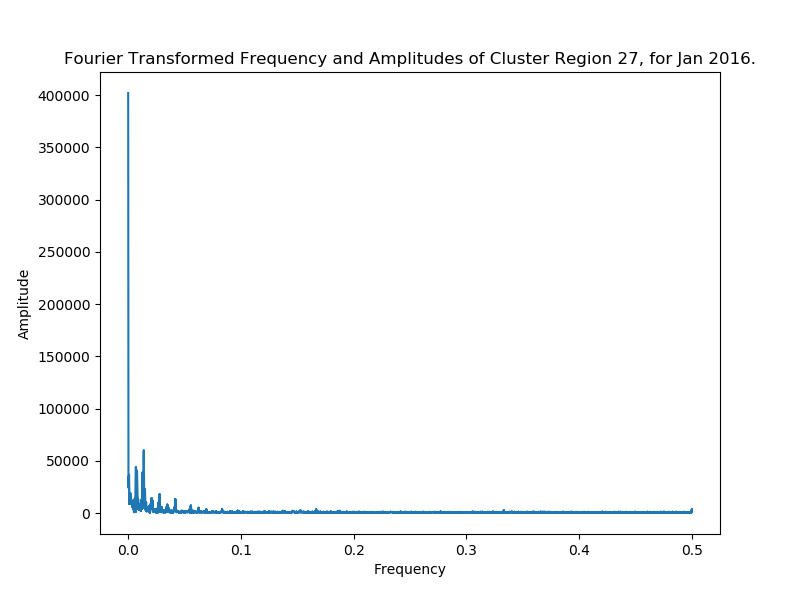

<IPython.core.display.Javascript object>


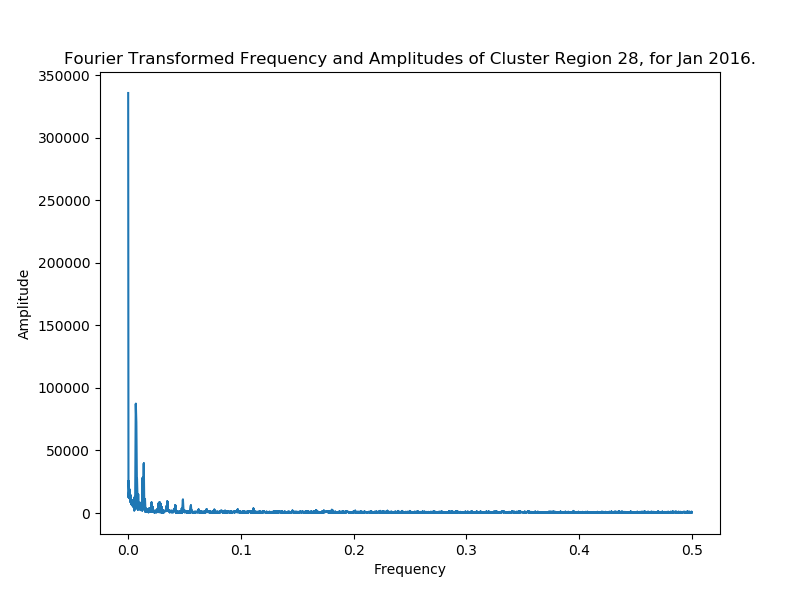

<IPython.core.display.Javascript object>


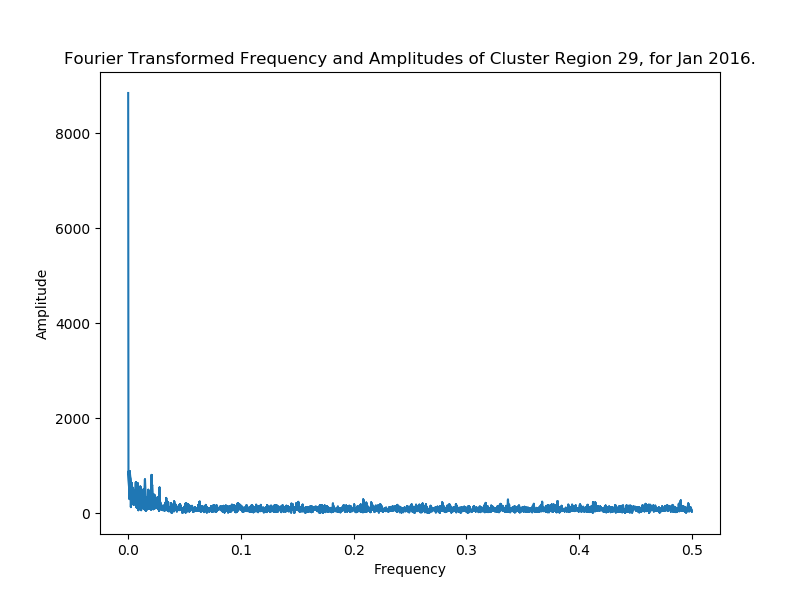

<IPython.core.display.Javascript object>


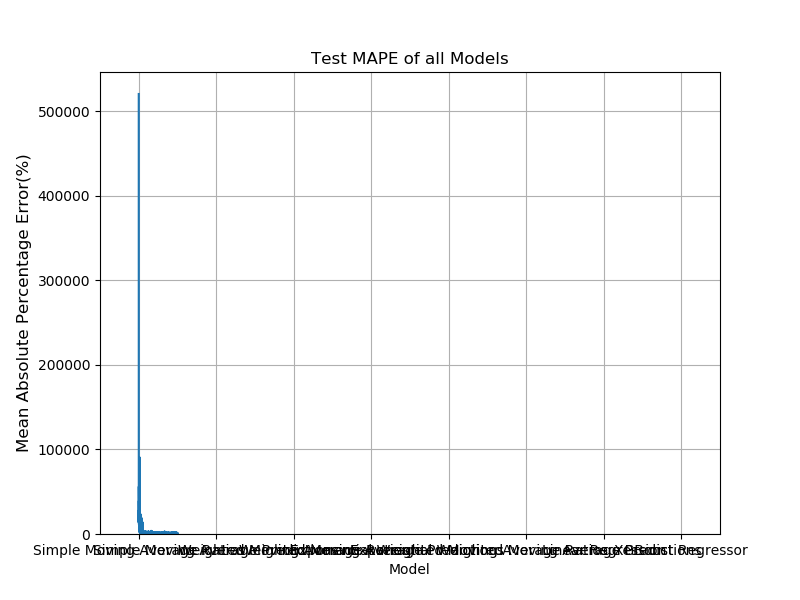

In [72]:
for i in range(30):
    Y  = np.abs(np.fft.fft(regionWisePickup_Jan_2016[i][0:4096]))
    freq = np.abs(np.fft.fftfreq(4096, 1))
    n = len(freq)
    plt.figure(figsize = (8, 6))
    plt.plot(freq[:], Y[:])
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.title("Fourier Transformed Frequency and Amplitudes of Cluster Region "+str(i+1)+", for Jan 2016.")
    plt.show()

In [73]:
amplitude_lists = []
frequency_lists = []
for i in range(30):
    ampli  = np.abs(np.fft.fft(regionWisePickup_Jan_2016[i][0:4096]))
    freq = np.abs(np.fft.fftfreq(4096, 1))
    ampli_indices = np.argsort(-ampli)[1:]       
    amplitude_values = []
    frequency_values = []
    for j in range(0, 9, 2):   
        amplitude_values.append(ampli[ampli_indices[j]])
        frequency_values.append(freq[ampli_indices[j]])
    for k in range(4459):    
        amplitude_lists.append(amplitude_values)
        frequency_lists.append(frequency_values) 

In [74]:
print("size of total train data :" +str(int(133770*0.8)))
print("size of total test data :" +str(int(133770*0.2)))

size of total train data :107016
size of total test data :26754


In [76]:
print("size of train data for one cluster:" +str(int(4459*0.8)))
print("size of total test data for one cluster:" +str(int(4459*0.2)))

size of train data for one cluster:3567
size of total test data for one cluster:891


In [77]:
train_previousFive_pickups  = [feat[i*4459:(4459*i+3567)] for i in range(30)]
test_previousFive_pickups  = [feat[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [78]:
train_fourier_frequencies = [frequency_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_frequencies = [frequency_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [79]:
train_fourier_amplitudes = [amplitude_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_amplitudes = [amplitude_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [80]:
print("Train Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of training points = {}".format(len(train_previousFive_pickups), len(train_previousFive_pickups[0]), len(train_previousFive_pickups)*len(train_previousFive_pickups[0])))
print("Test Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of test points = {}".format(len(test_previousFive_pickups), len(test_previousFive_pickups[0]), len(test_previousFive_pickups)*len(test_previousFive_pickups[0])))

Train Data: Total number of clusters = 30. Number of points in each cluster = 3567. Total number of training points = 107010
Test Data: Total number of clusters = 30. Number of points in each cluster = 892. Total number of test points = 26760


In [81]:
train_lat = [i[:3567] for i in lat]
train_lon = [i[:3567] for i in lon]
train_weekDay = [i[:3567] for i in day_of_week]
train_weighted_avg = [i[:3567] for i in predicted_pickup_values_list]
train_TruePickups = [i[:3567] for i in TruePickups]

In [82]:
test_lat = [i[3567:] for i in lat]
test_lon = [i[3567:] for i in lon]
test_weekDay = [i[3567:] for i in day_of_week]
test_weighted_avg = [i[3567:] for i in predicted_pickup_values_list]
test_TruePickups = [i[3567:] for i in TruePickups]

In [83]:
train_pickups = []
test_pickups = []
train_freq = []
test_freq = []
train_amp = []
test_amp = []
for i in range(30):
    train_pickups.extend(train_previousFive_pickups[i])
    test_pickups.extend(test_previousFive_pickups[i])
    train_freq.extend(train_fourier_frequencies[i])
    test_freq.extend(test_fourier_frequencies[i])
    train_amp.extend(train_fourier_amplitudes[i])
    test_amp.extend(test_fourier_amplitudes[i])

In [84]:
train_prevPickups_freq_amp = np.hstack((train_pickups, train_freq, train_amp))
test_prevPickups_freq_amp = np.hstack((test_pickups, test_freq, test_amp))

In [85]:
print("Number of data points in train data = {}. Number of columns till now = {}".format(len(train_prevPickups_freq_amp), len(train_prevPickups_freq_amp[0])))
print("Number of data points in test data = {}. Number of columns till now = {}".format(len(test_prevPickups_freq_amp), len(test_prevPickups_freq_amp[0])))

Number of data points in train data = 107010. Number of columns till now = 15
Number of data points in test data = 26760. Number of columns till now = 15


In [86]:
train_flat_lat = sum(train_lat, [])
train_flat_lon = sum(train_lon, [])
train_flat_weekDay = sum(train_weekDay, [])
train_weighted_avg_flat = sum(train_weighted_avg, [])
train_TruePickups_flat = sum(train_TruePickups, [])

test_flat_lat = sum(test_lat, [])
test_flat_lon = sum(test_lon, [])
test_flat_weekDay = sum(test_weekDay, [])
test_weighted_avg_flat = sum(test_weighted_avg, [])
test_TruePickups_flat = sum(test_TruePickups, [])

In [87]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'freq1', 'freq2','freq3','freq4','freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp5']
Train_DF = pd.DataFrame(data = train_prevPickups_freq_amp, columns = columns)
Train_DF["Latitude"] = train_flat_lat
Train_DF["Longitude"] = train_flat_lon
Train_DF["WeekDay"] = train_flat_weekDay
Train_DF["WeightedAvg"] = train_weighted_avg_flat

In [88]:
Test_DF = pd.DataFrame(data = test_prevPickups_freq_amp, columns = columns)
Test_DF["Latitude"] = test_flat_lat
Test_DF["Longitude"] = test_flat_lon
Test_DF["WeekDay"] = test_flat_weekDay
Test_DF["WeightedAvg"] = test_weighted_avg_flat

In [89]:
print("Shape of train data = "+str(Train_DF.shape))
print("Shape of test data = "+str(Test_DF.shape))

Shape of train data = (107010, 19)
Shape of test data = (26760, 19)


In [90]:
Train_DF.head()

ft_5   ft_4   ft_3   ft_2   ft_1     freq1    freq2     freq3     freq4  \
0   39.0   88.0  137.0  177.0  163.0  0.006836  0.00708  0.013916  0.012939   
1   88.0  137.0  177.0  163.0  175.0  0.006836  0.00708  0.013916  0.012939   
2  137.0  177.0  163.0  175.0  181.0  0.006836  0.00708  0.013916  0.012939   
3  177.0  163.0  175.0  181.0  173.0  0.006836  0.00708  0.013916  0.012939   
4  163.0  175.0  181.0  173.0  194.0  0.006836  0.00708  0.013916  0.012939   

      freq5          Amp1          Amp2          Amp3         Amp4  \
0  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   
1  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   
2  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   
3  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   
4  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   

           Amp5   Latitude  Longitude  WeekDay  WeightedAvg  
0  20486.030469  40.785278 -73.949445        5          167  
1  20486.030469  40.785278 -73.949445        5          171  
2  20486.030469  40.785278 -73.949445        5          179  
3  20486.030469  40.785278 -73.949445        5          175  
4  20486.030469  40.785278 -73.949445        5          187

In [91]:
Test_DF.head()

ft_5   ft_4   ft_3   ft_2   ft_1     freq1    freq2     freq3     freq4  \
0   86.0   91.0   72.0   94.0  122.0  0.006836  0.00708  0.013916  0.012939   
1   91.0   72.0   94.0  122.0   81.0  0.006836  0.00708  0.013916  0.012939   
2   72.0   94.0  122.0   81.0   71.0  0.006836  0.00708  0.013916  0.012939   
3   94.0  122.0   81.0   71.0   69.0  0.006836  0.00708  0.013916  0.012939   
4  122.0   81.0   71.0   69.0   51.0  0.006836  0.00708  0.013916  0.012939   

      freq5          Amp1          Amp2          Amp3         Amp4  \
0  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   
1  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   
2  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   
3  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   
4  0.000977  54178.696552  44598.078079  43153.235504  21621.39267   

           Amp5   Latitude  Longitude  WeekDay  WeightedAvg  
0  20486.030469  40.785278 -73.949445        1          112  
1  20486.030469  40.785278 -73.949445        1           94  
2  20486.030469  40.785278 -73.949445        1           74  
3  20486.030469  40.785278 -73.949445        1           69  
4  20486.030469  40.785278 -73.949445        1           57

## Linear Regression

In [92]:
def lin_regression(train_data, train_true, test_data, test_true):
    
    #standardizing the data
    train_std = StandardScaler().fit_transform(train_data)
    test_std = StandardScaler().fit_transform(test_data)
    
    #hyper-paramater tuning
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
    values = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_std, train_true)
    alpha = best_parameter.best_params_["alpha"]
    
    #applying linear regression with best hyper-parameter
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(train_std, train_true)
    train_pred = clf.predict(train_std)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_std)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

## Random Forest Regressor

In [93]:
def randomFor(train_data, train_true, test_data, test_true):
    
    #hyper-paramater tuning
    values = [10, 40, 80, 150, 600, 800]
    clf = RandomForestRegressor(n_jobs = -1)
    hyper_parameter = {"n_estimators": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    
    #applying random forest with best hyper-parameter
    clf = RandomForestRegressor(n_estimators = estimators, n_jobs = -1)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [95]:
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr = lin_regression(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf = randomFor(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)

In [102]:
error_table_regressions = pd.DataFrame(columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"])

error_table_regressions = error_table_regressions.append(pd.DataFrame([["Linear Regression", trainMAPE_lr*100, trainMSE_lr, testMAPE_lr*100, testMSE_lr ]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions = error_table_regressions.append(pd.DataFrame([["Random Forest Regression", trainMAPE_rf*100, trainMSE_rf, testMAPE_rf*100, testMSE_rf]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions.reset_index(drop = True, inplace = True)